#Mount Drive

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = "/content/drive/My Drive/Colab Notebooks/COP509cw/Datasets/"
!ls "/content/drive/My Drive/Colab Notebooks/COP509cw/Datasets/"

dataset = 'JewelleryReviewsLSA.csv'
query = 'JewelleryReviewsQueryRelevantID.csv'
summary = 'JewelleryReviewsSummarisationTargets.csv'

JewelleryReviewsLSA.csv		     JewelleryReviewsQueryRelevantID.gsheet
JewelleryReviewsLSA.gsheet	     JewelleryReviewsSummarisationTargets.csv
JewelleryReviewsQueryRelevantID.csv


In [ ]:
import pandas as pd
import nltk; 
from nltk.corpus import stopwords
import string 
from collections import Counter
from nltk.tokenize import word_tokenize
nltk.download('popular')

# Question 1

#### Pre-process the Dataset

Load file into memory and Perform Tokenization (Word & Sentence), Stop word removal, Stemming, removal of short tokens


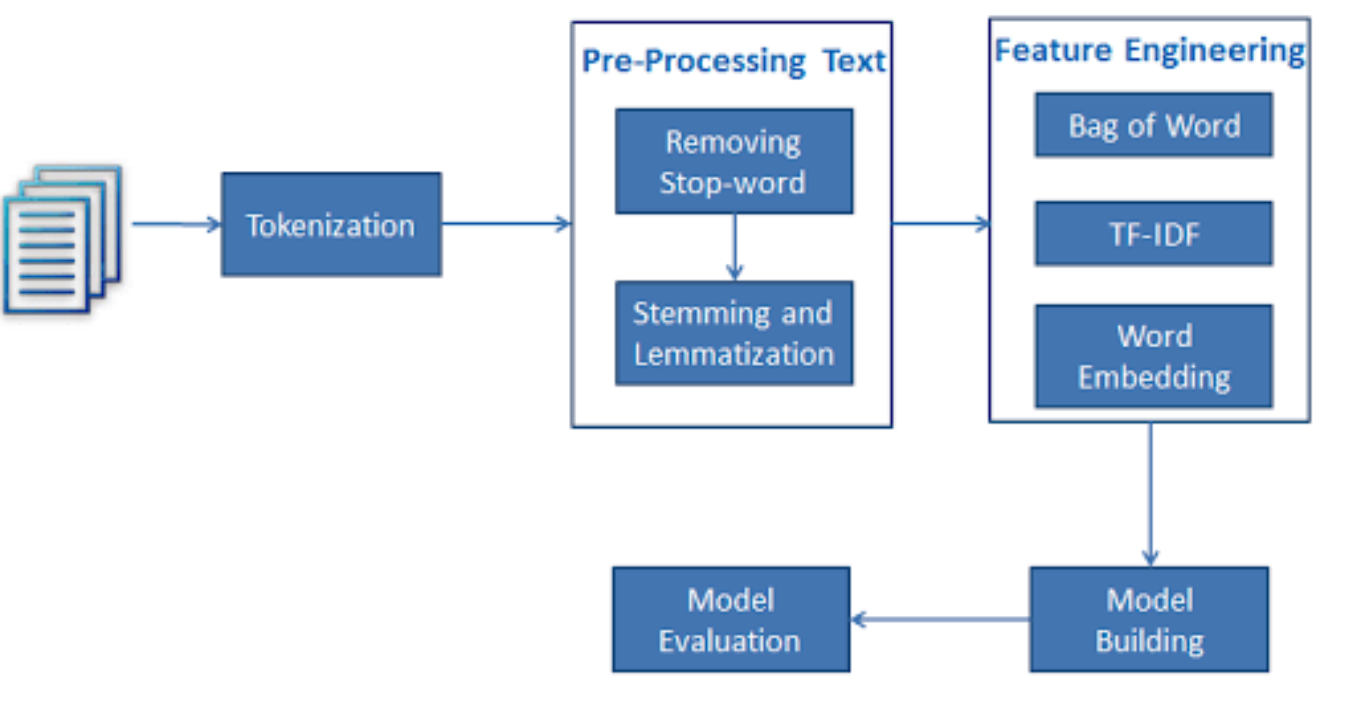

In [ ]:
# load doc into memory
def load_doc(filename):
	# open the csv file as read into memory
	df = pd.read_csv(filename, delimiter=',', header=0)

	return df

# turn a doc into clean tokens
# This code was copied from - (link)
# Source - Lab solutions for 22COP509 NLP course
def clean_doc_vocab(doc):
	tokens = word_tokenize(doc)
	# convert to lower case
	tokens = [w.lower() for w in tokens]
	#remove duplicate words
	tokens = set(tokens)
	# remove punctuation from each token
	table = str.maketrans('', '', string.punctuation)
	tokens = [w.translate(table) for w in tokens]
	# remove remaining tokens that are not alphabetic
	tokens = [word for word in tokens if word.isalpha()]
	# filter out stop words
	stop_words = set(stopwords.words('english'))
	tokens = [w for w in tokens if not w in stop_words]
	# filter out short tokens
	tokens = [word for word in tokens if len(word) > 1]

	return tokens

# load doc and add to vocab
# This code was adapted from - (link)
def add_doc_to_vocab(doc, vocab):
	# clean doc
	tokens = clean_doc_vocab(doc)
	# update counts
	vocab.update(tokens)

 # save list to file
 # # This code was copied from - [https://colab.research.google.com/drive/1dTFUKVnqCJVvQckf0kbfaFNb8kK7bX5y?usp=sharing#scrollTo=NKc7lfr6D-ts]
def save_list(lines, filename):
	# convert lines to a single blob of text
	data = '\n'.join(lines)
	# open file
	file = open(filename, 'w')
	# write text
	file.write(data)
	# close file
	file.close()
 
def build_vocab(reviews, vocab):
	# iterate through each row of the dataframe and build vocab from token
	for index, row in reviews.iterrows():
		add_doc_to_vocab(row['Reviews'], vocab) 	

	# keep tokens with a min occurrence - This code was copied from - (link)
	min_occurane = 2
	tokens = [k for k,c in vocab.items() if c >= min_occurane]

	# Save vocab list in a text file
	save_list(tokens, 'vocab.txt')
 
#Load data
data = load_doc(data_path + dataset)

# View data summary to check for possible null records
print(data.shape)

vocab = Counter()
lines = build_vocab(data, vocab)
# print the size of the vocab
print(len(vocab))
# print the top words in the vocab
print(vocab.most_common(50))

# keep tokens with a min occurrence
min_occurane = 2
tokens = [k for k,c in vocab.items() if c >= min_occurane]
print(len(tokens))

# # This code block was copied from - [https://colab.research.google.com/drive/1dTFUKVnqCJVvQckf0kbfaFNb8kK7bX5y?usp=sharing#scrollTo=NKc7lfr6D-ts]
# load documents, clean and return line of tokens
def doc_to_line(doc, vocab):
	# clean doc
	tokens = clean_doc_vocab(doc)
	# filter by vocab
	tokens = [w for w in tokens if w in vocab]
	return ' '.join(tokens)
 
 # load all docs in a directory
def process_docs(doc, vocab):
	lines = list()
	docs = list()
  
	# walk through all files
	for index, row in doc.iterrows():
		# load and clean the doc
		line = doc_to_line(row['Reviews'], vocab)
		# add to list
		lines.append(line)
		docs.append(row['Reviews'])
  
	return lines, docs

def read_file(doc):
  # load data
  file = open(doc,'rt')
  text = file.read()
  file.close()

  return text


(200, 3)
1090
[('ring', 105), ('like', 44), ('quality', 38), ('rings', 34), ('looks', 34), ('would', 33), ('look', 32), ('one', 32), ('wear', 32), ('picture', 32), ('nt', 31), ('beautiful', 31), ('love', 30), ('item', 26), ('great', 24), ('nice', 24), ('time', 19), ('bought', 19), ('silver', 17), ('small', 17), ('size', 16), ('got', 16), ('pretty', 16), ('price', 15), ('received', 15), ('perfect', 15), ('first', 14), ('recommend', 14), ('gift', 14), ('little', 14), ('looking', 14), ('color', 14), ('even', 13), ('really', 12), ('product', 12), ('buy', 12), ('looked', 12), ('definitely', 11), ('also', 11), ('diamond', 10), ('seller', 10), ('wedding', 10), ('diamonds', 10), ('right', 10), ('purchased', 10), ('wanted', 10), ('wearing', 10), ('much', 10), ('order', 10), ('stones', 10)]
450


#### Build Bag of Words

In [ ]:
# load the vocabulary
vocab_filename = 'vocab.txt'
vocab = read_file(vocab_filename)
vocab = vocab.split()
vocab = set(vocab)

# load all training reviews
reviews, docs = process_docs(data, vocab)

# Question 2 - Latent Semantic Indexing (LSI)

Latent Semantic Indexing is a natural language processing technique that analyzes relationships between a set of documents and the terms they contain. Singular Value Decomposition (SVD) is used by LSI to transform the original term-document matrix into a lower-dimensional space where the relationships between terms and documents are represented as latent (hidden) concepts. This enables LSI to capture the underlying semantic meaning of words and identify related documents even when they lack many common terms. LSI has found widespread application in information retrieval, text classification, and topic modeling.

[Src - Databricks Academy](https://www.youtube.com/watch?v=YX4xRIQ84Z0&t=46s)
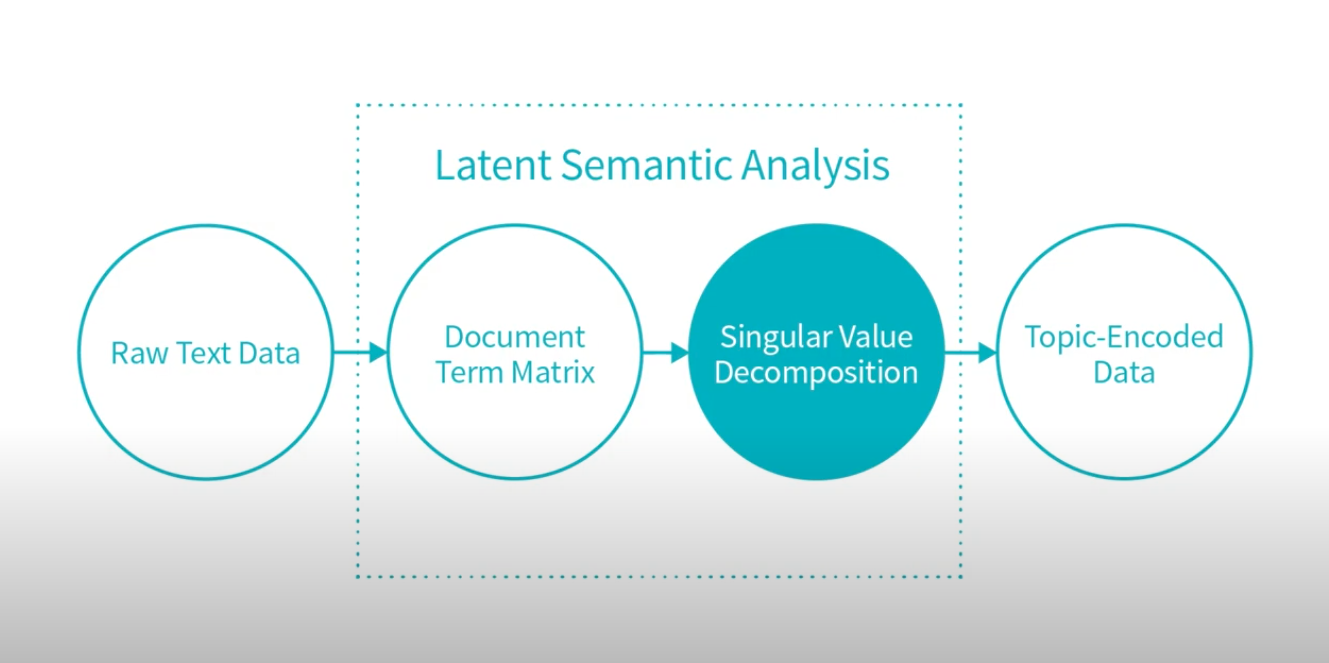

## 2a - Retrieve Top 10 most similar reviews

Retrieval comprises of performing three primary steps—generate a representation of the query that specifies the information need, generate a representation of the document that captures the distribution over the information contained, and match the query and the document representations to estimate their mutual relevance.

In doing so, Document ranking is employed. This ranking typically involves a query and document representation steps, followed by a matching stage. Neural models can be useful either for generating good representations or in estimating relevance, or both.

Mitra, B. and Craswell, N. (2018) [An Introduction to Neural Information Retrieval, Microsoft.com. doi: 10.1561/1500000061.](https://www.microsoft.com/en-us/research/uploads/prod/2017/06/INR-061-Mitra-neuralir-intro.pdf)


#### Perform Encoding

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import rand
from sklearn.metrics.pairwise import cosine_similarity
# prepare words encoding of docs - TF-IDF Approach
# # This code block was copied from - https://colab.research.google.com/drive/1BXr4DuL-uKdQeTHUI_jVfhyuAykrair8?usp=sharing#scrollTo=xZk_Cppdf0Sk
def prepare_data(train_docs, mode, vocab):
	# encode training data set
	vectorizer = CountVectorizer(vocabulary=vocab)
	transformer = TfidfTransformer(norm='l2')
	Xtrain = transformer.fit_transform(vectorizer.fit_transform(train_docs))
	return Xtrain

# # This code block was copied from - https://colab.research.google.com/drive/1gonQXIxPTDk7WUsbDQ2G7neURoWP6efH#scrollTo=HFeOO9Ca-BX-&line=12&uniqifier=1
# preprocess query
def preprocess_query(query, mode, vocab):
  line = doc_to_line(query, vocab)
  vectorizer = CountVectorizer(vocabulary=vocab)
  transformer = TfidfTransformer(norm='l2')
  encoded = transformer.fit_transform(vectorizer.fit_transform([line]))
  return encoded

Xtrain = prepare_data(reviews, 'tfidf', vocab)
trunc_SVD_model = TruncatedSVD(n_components=5)
approx_Xtrain = trunc_SVD_model.fit_transform(Xtrain)
print("Approximated Xtrain shape: " + str(approx_Xtrain.shape))


Approximated Xtrain shape: (200, 5)


In [ ]:
import numpy as np

querys = ['The ring is a great gift. My friend loves it',
          'horrible bad quality bracelet',
          'arrived promptly and happy with the seller',
          'wear it with casual wear',
          'i expected better quality. i will return this item',
          'looks beautiful. The design is pretty. pefect and color is light',
          'This ring looks nothing like the picture. the diamonds are small and not very noticeable',
          'braclet looked just like its picture and is nice quality sterling silver.'
]


doc_ids = list()
for index, query in enumerate(querys):
  Top_n_reviews=10
  # retrieval
  encoded_query = preprocess_query(query, 'tfidf', vocab)
  # print(encoded_query.shape)

  transformed_query = trunc_SVD_model.transform(encoded_query)
  similarities = cosine_similarity(approx_Xtrain, transformed_query)
  # print("Similarities shape: " + str(similarities.shape))
  indexes = np.argsort(similarities.flat)[-Top_n_reviews:]
  doc_id = [data.iloc[indexes[i]]['ID'] for i in range(len(indexes))]
  doc_ids.append(doc_id)
  # indexes = np.argsort(similarities.flat)[::-1]
  
  print('_'*100)
  print(f'Query {index + 1}: {query}')
  print('='*100)
  print(f"Top {Top_n_reviews} documents retrieved:  {str(doc_id)}")
  # print(f"Top {Top_n_reviews} documents retrieved:  {data.iloc[indexes]["ID"]}")
  similarity_score = ', '.join([str(round(score, 3)) for score in similarities.
                                flat[indexes]])
  print(f"\nSimilarities scores: {similarity_score}")
  print('='*100)
  for i in range(Top_n_reviews, 0, -1):
    print(f"{i}th Ranked result:")
    print("Doc ID: " + str(indexes[-i]))
    # print("ID"+ str(data.iloc[indexes[i]]))
    # print(reviews[indexes[-i]])
    print(docs[indexes[-i]])
    print("Similarities: " + str(similarities.flat[indexes[-i]]))
    print('\n')

____________________________________________________________________________________________________
Query 1: The ring is a great gift. My friend loves it
Top 10 documents retrieved:  [9726, 26246, 2033, 17309, 35694, 41876, 17273, 44591, 36164, 49525]

Similarities scores: 0.942, 0.956, 0.96, 0.966, 0.971, 0.976, 0.979, 0.985, 0.99, 0.995
10th Ranked result:
Doc ID: 109
A great gift to your loved one and an ever better seller. The seller deals with you in the most professional way and the security measures are superb.
Similarities: 0.9417843172724708


9th Ranked result:
Doc ID: 105
This was a birthday gift for my 16 YO niece. She loves the ring and was very happy to have received it.
Similarities: 0.956203726922509


8th Ranked result:
Doc ID: 106
I love my birthstone and I wanted a piece of jewelry that symbolized the simple purity of the Blue Topaz. This ring did that for me. As a gift to myself for my birthday this year, it was definitely a great gift and a welcomed addition to my

## 2b - Emperically Tune the LSI model

Define functions for Emperical tuning of Weighting schemes

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

def prepare_tf_data(train_docs, mode, vocab):
  # encode training data set
	vectorizer = CountVectorizer(vocabulary=vocab)
	transformer = TfidfTransformer(norm=None, use_idf=False, sublinear_tf=True)
	Xtrain = transformer.fit_transform(vectorizer.fit_transform(train_docs))
	return Xtrain

def preprocess_tf_query(query, mode, vocab):
  line = doc_to_line(query, vocab)
  vectorizer = CountVectorizer(vocabulary=vocab)
  transformer = TfidfTransformer(norm=None, use_idf=False, sublinear_tf=True)
  encoded = transformer.fit_transform(vectorizer.fit_transform([line]))
  return encoded

# prepare words encoding of docs - Training emperically
# # This code block was copied from - https://colab.research.google.com/drive/1BXr4DuL-uKdQeTHUI_jVfhyuAykrair8?usp=sharing#scrollTo=xZk_Cppdf0Sk
def _prepare_data(train_docs, mode, vocab):
  # Tune the LSI model
  if mode == 'tfidf':
    encoded = prepare_data(train_docs, mode, vocab)
  if mode == 'binary':
    transformer = CountVectorizer(vocabulary=vocab, binary=True)
  if mode == 'count':
    transformer = CountVectorizer(vocabulary=vocab)
  if mode == 'tf':
    encoded = prepare_tf_data(train_docs, mode, vocab)

  return encoded

# # This code block was copied from - https://colab.research.google.com/drive/1gonQXIxPTDk7WUsbDQ2G7neURoWP6efH#scrollTo=HFeOO9Ca-BX-&line=12&uniqifier=1
# preprocess query
def _preprocess_query(query, mode, vocab):
  line = doc_to_line(query, vocab)
  # Tune the LSI model
  #   for scheme in weighting_schemes:
  if mode == 'tfidf':
    transformed = preprocess_query(query, mode, vocab)
  if mode == 'binary':
    transformed = CountVectorizer(vocabulary=vocab, binary=True)
  if mode == 'count':
    transformed = CountVectorizer(vocabulary=vocab)
  if mode == 'tf':
    transformed = preprocess_tf_query(query, mode, vocab)

  return transformed

# Xtrain = _prepare_data(reviews, 'tfidf', vocab)
# trunc_SVD_model = TruncatedSVD(n_components=5)
# approx_Xtrain = trunc_SVD_model.fit_transform(Xtrain)
# print("Approximated Xtrain shape: " + str(approx_Xtrain.shape))



##### Define Evaluation Metrics



In [ ]:
# Interplot Precision for standard Recall
def InterplotPrecision(p=0.1, Precision=None, Recall=None):

    if p >= 1.0:
        p = 0.9

    Mark = np.zeros(2)
    l = 0
    r = 0
    for i in range(len(Recall)):
        if Recall[i] >= p and Mark[0] == 0:
            l = i
            Mark[0] = 1
        if Recall[i] >= p + 0.1 and Mark[1] == 0:
        # if Recall[i] >= 1.0 and Mark[1] == 0:
            r = i
            Mark[1] = 1
    y = max(Precision[l:(r+1)])
    return y

# obtain y axis for R/P curve
def compute_RP_yaxis(Precision=None, Recall=None):
  y_axis = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  for i in range(11):
    pInput = 0.1 * i
    y_axis[i] = InterplotPrecision(p=pInput, Precision=Precision, Recall=Recall)
  return y_axis

# compute Recall, Precision, F1-measure
def compute_R_P_F1(re_mark=None, QuRe_ID =None):
  Recall = []
  Precision = []
  F1measure = []
  for i in range(len(re_mark)):
    r = sum(re_mark[:(i+1)])
    Re = r/(len(QuRe_ID))
    Pr = r/(i+1)   
    # avoid divisor to be 0
    FD = Re + Pr 
    if FD == 0:
      FD=1
    F1 = 2*Re*Pr/FD

    Recall.append(Re)
    Precision.append(Pr)
    F1measure.append(F1)
  return Recall, Precision, F1measure


### Evaluate LSI models

###### Deprecated *LSI*


Query1: The ring is a great gift. My friend loves it
Recall@1~10:  [0.   0.06 0.06 0.06 0.06 0.12 0.12 0.12 0.19 0.25]
Precision@1~10:  [0.   0.5  0.33 0.25 0.2  0.33 0.29 0.25 0.33 0.4 ]
F1measure@1~10:  [0.   0.11 0.11 0.1  0.1  0.18 0.17 0.17 0.24 0.31]


<ipython-input-10-1e3085a49a4c>:64: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x_axis, y_axis, '-bo', color="purple", label="Query%d"%(j+1))


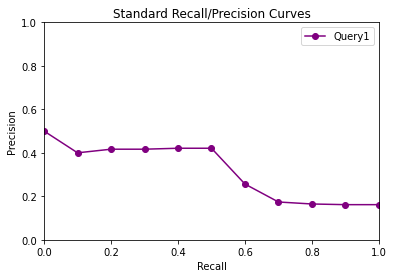


Query2: horrible bad quality bracelet
Recall@1~10:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Precision@1~10:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
F1measure@1~10:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


<ipython-input-10-1e3085a49a4c>:64: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x_axis, y_axis, '-bo', color="purple", label="Query%d"%(j+1))


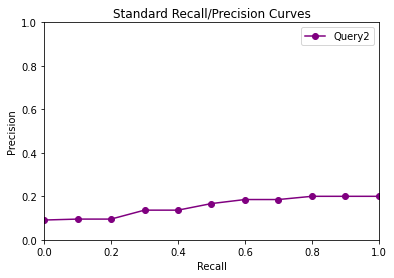


Query3: arrived promptly and happy with the seller
Recall@1~10:  [0.   0.   0.   0.   0.   0.07 0.07 0.14 0.14 0.14]
Precision@1~10:  [0.   0.   0.   0.   0.   0.17 0.14 0.25 0.22 0.2 ]
F1measure@1~10:  [0.   0.   0.   0.   0.   0.1  0.1  0.18 0.17 0.17]


<ipython-input-10-1e3085a49a4c>:64: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x_axis, y_axis, '-bo', color="purple", label="Query%d"%(j+1))


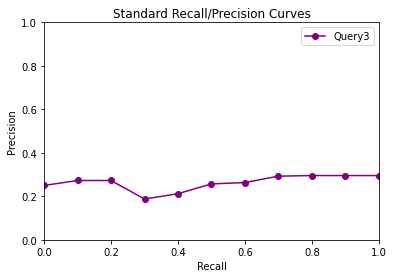


Query4: wear it with casual wear
Recall@1~10:  [0.   0.   0.07 0.14 0.21 0.29 0.36 0.43 0.5  0.5 ]
Precision@1~10:  [0.   0.   0.33 0.5  0.6  0.67 0.71 0.75 0.78 0.7 ]
F1measure@1~10:  [0.   0.   0.12 0.22 0.32 0.4  0.48 0.55 0.61 0.58]


<ipython-input-10-1e3085a49a4c>:64: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x_axis, y_axis, '-bo', color="purple", label="Query%d"%(j+1))


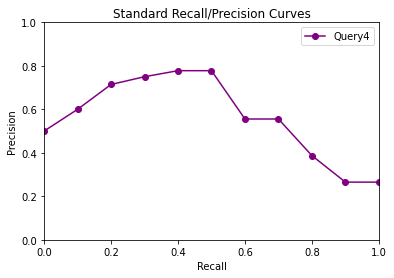

<ipython-input-10-1e3085a49a4c>:64: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x_axis, y_axis, '-bo', color="purple", label="Query%d"%(j+1))



Query5: i expected better quality. i will return this item
Recall@1~10:  [0.2 0.2 0.2 0.4 0.4 0.4 0.4 0.4 0.4 0.6]
Precision@1~10:  [1.   0.5  0.33 0.5  0.4  0.33 0.29 0.25 0.22 0.3 ]
F1measure@1~10:  [0.33 0.29 0.25 0.44 0.4  0.36 0.33 0.31 0.29 0.4 ]


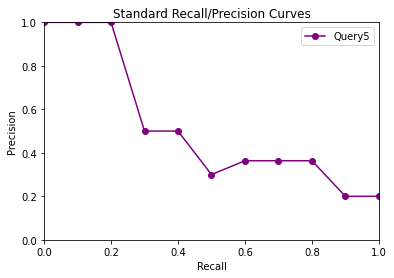


Query6: looks beautiful. The design is pretty. pefect and color is light
Recall@1~10:  [0.08 0.08 0.17 0.25 0.25 0.25 0.25 0.25 0.25 0.25]
Precision@1~10:  [1.   0.5  0.67 0.75 0.6  0.5  0.43 0.38 0.33 0.3 ]
F1measure@1~10:  [0.15 0.14 0.27 0.38 0.35 0.33 0.32 0.3  0.29 0.27]


<ipython-input-10-1e3085a49a4c>:64: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x_axis, y_axis, '-bo', color="purple", label="Query%d"%(j+1))


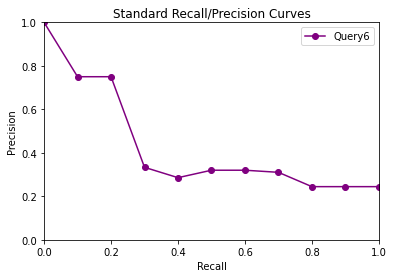


Query7: This ring looks nothing like the picture. the diamonds are small and not very noticeable
Recall@1~10:  [0.07 0.14 0.21 0.29 0.36 0.43 0.5  0.57 0.64 0.71]
Precision@1~10:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
F1measure@1~10:  [0.13 0.25 0.35 0.44 0.53 0.6  0.67 0.73 0.78 0.83]


<ipython-input-10-1e3085a49a4c>:64: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x_axis, y_axis, '-bo', color="purple", label="Query%d"%(j+1))


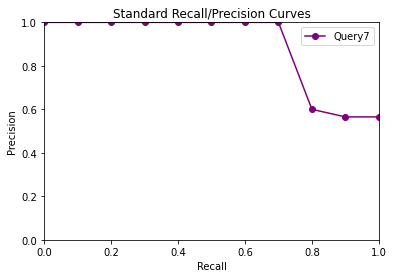


Query8: braclet looked just like its picture and is nice quality sterling silver.
Recall@1~10:  [0.08 0.15 0.23 0.31 0.38 0.46 0.54 0.62 0.62 0.62]
Precision@1~10:  [1.   1.   1.   1.   1.   1.   1.   1.   0.89 0.8 ]
F1measure@1~10:  [0.14 0.27 0.38 0.47 0.56 0.63 0.7  0.76 0.73 0.7 ]


<ipython-input-10-1e3085a49a4c>:64: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x_axis, y_axis, '-bo', color="purple", label="Query%d"%(j+1))


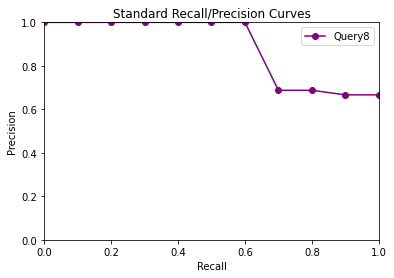


Average Recall, average Precision, average F1-measure: 
average Recall@1~10:  [0.05 0.08 0.12 0.18 0.21 0.25 0.28 0.32 0.34 0.38]
average Precision@1~10:  [0.5  0.44 0.46 0.5  0.48 0.5  0.48 0.48 0.47 0.46]
average F1measure@1~10:  [0.1  0.13 0.18 0.26 0.28 0.33 0.35 0.37 0.39 0.41]


<ipython-input-10-1e3085a49a4c>:91: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x_axis, y_axis, '-bo', color="blue", label="Average")


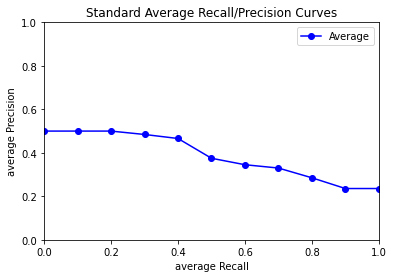

In [ ]:
Xtrain = _prepare_data(reviews, 'tf', vocab)
trunc_SVD_model = TruncatedSVD(n_components=5)
approx_Xtrain = trunc_SVD_model.fit_transform(Xtrain)

re_ID = [[36164,58481,26246,2033,48779,34523,9726,56494,49525,45278,35694,41876,17309,11135,17273,11247],
         [57123,25299,55017,7432,2114,40871],
         [33251,17304,50019,27679,6158,22408,29722,36677,2780,17944,19944,31657,52867,49216],
         [40373,28648,37486,30640,2131,19852,2134,36585,26535,51474,21070,56330,53660,44126],
         [13373,17607,41459,54748,33571],
         [45860,46500,27474,43945,52837,12358,41319,39932,45146,50197,8341,52375],
         [209,28542,216,47345,11356,33632,38637,7110,6649,51356,44358,36165,943,37864],
         [642,10642,37794,45518,3494,735,10037,41872,28542,53409,56865,44489,44490]]


AllRecall = list()
AllPrecision = list()
AllF1measure = list()
_y_axis_lsi_tf = list()
_y_axis_lsi_tfidf = list()
# loop queries
j = 0
for query in querys:
  # retrieval
  encoded_query = _preprocess_query(query, 'tf', vocab)
  transformed_query = trunc_SVD_model.transform(encoded_query)
  similarities = cosine_similarity(approx_Xtrain, transformed_query)

  # rank the index
  indexes = np.argsort(similarities.flat)[::-1]
  doc_id = [data.iloc[indexes[i]]['ID'] for i in range(len(indexes))]

  # Mark the relevant index
  re_mark = []
  for i in range(len(indexes)):
    if (doc_id[i]) in re_ID[j]:
      re_mark.append(1)
    else:
      re_mark.append(0)
  # print(re_mark)

  # compute Recall, Precision, F1-measure
  Recall, Precision, F1measure = compute_R_P_F1(re_mark=re_mark, QuRe_ID=re_ID[j])
  
  print('\n' + 'Query%d: '%(j+1) + query)
  # for i in range(10):
  #   print("Top " + str(i+1) + ' result: ID%d '%(indexes[i]+1), ArRe_train_lines[indexes[i]])
  Recall = np.array(Recall)
  Precision = np.array(Precision)
  F1measure = np.array(F1measure)
  # print(re_mark)
  print("Recall@1~10: ", np.around(Recall[:10],2))
  print("Precision@1~10: ", np.around(Precision[:10],2))
  print("F1measure@1~10: ", np.around(F1measure[:10],2))

  # save
  AllRecall.append(Recall)
  AllPrecision.append(Precision)
  AllF1measure.append(F1measure)

  # plot R/P curve
  x_axis = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
  y_axis = compute_RP_yaxis(Precision=Precision, Recall=Recall)
  _y_axis_lsi_tfidf.append(y_axis)
  plt.plot(x_axis, y_axis, '-bo', color="purple", label="Query%d"%(j+1))
  plt.xlim(0, 1)
  plt.ylim(0, 1)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Standard Recall/Precision Curves')
  plt.legend()
  plt.show()

  j += 1

# compute average Recall, average Precision, average F1-measure
AllRecall = np.array(AllRecall)
AllPrecision = np.array(AllPrecision)
AllF1measure = np.array(AllF1measure)
AveRecall = (AllRecall[0] + AllRecall[1] + AllRecall[2] + AllRecall[3] + AllRecall[4] + AllRecall[5] + AllRecall[6] + AllRecall[7])/8
AvePrecision = (AllPrecision[0] + AllPrecision[1]+AllPrecision[2] + AllPrecision[3]+AllPrecision[4] + AllPrecision[5] + AllPrecision[6] + AllPrecision[7])/8
AveF1measure = (AllF1measure[0] + AllF1measure[1]+AllF1measure[2] + AllF1measure[3]+AllF1measure[4] + AllF1measure[5] + AllF1measure[6] + AllF1measure[7])/8

print("\nAverage Recall, average Precision, average F1-measure: ")
print("average Recall@1~10: ", np.around(AveRecall[:10],2))
print("average Precision@1~10: ", np.around(AvePrecision[:10],2))
print("average F1measure@1~10: ", np.around(AveF1measure[:10],2))

# plot average R/P curve
x_axis = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
y_axis = compute_RP_yaxis(Precision=AvePrecision, Recall=AveRecall)
plt.plot(x_axis, y_axis, '-bo', color="blue", label="Average")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('average Recall')
plt.ylabel('average Precision')
plt.title('Standard Average Recall/Precision Curves')
plt.legend()
plt.show()

LSI_y_axis_avg = y_axis

###### Adapted LSI implementation

#### Tune with TFIDF and SVD dimension of 5


Results for top n docs returned for each query:
+--------+-----------------------------------------------------+-----------------------------------------------------+-----------------------------------------------------+
| Query  |                     Recall@1~10                     |                    Precision@1~10                   |                    F1measure@1~10                   |
+--------+-----------------------------------------------------+-----------------------------------------------------+-----------------------------------------------------+
| Query1 | [0.06 0.12 0.12 0.19 0.25 0.31 0.38 0.44 0.5  0.5 ] | [1.   1.   0.67 0.75 0.8  0.83 0.86 0.88 0.89 0.8 ] | [0.12 0.22 0.21 0.3  0.38 0.45 0.52 0.58 0.64 0.62] |
| Query2 | [0.   0.   0.   0.17 0.17 0.17 0.17 0.17 0.17 0.17] | [0.   0.   0.   0.25 0.2  0.17 0.14 0.12 0.11 0.1 ] | [0.   0.   0.   0.2  0.18 0.17 0.15 0.14 0.13 0.12] |
| Query3 | [0.   0.07 0.14 0.21 0.29 0.29 0.29 0.29 0.29 0.29] | [0.   0.5  0.67 0.75 

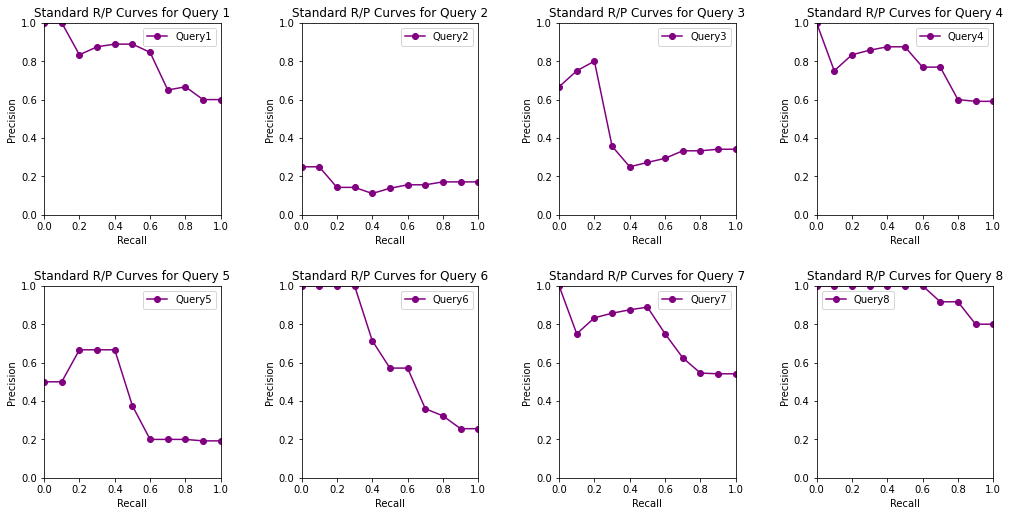

+-------+----------------+-------------------+-------------------+
| Query | Average Recall | Average Precision | Average F1measure |
+-------+----------------+-------------------+-------------------+
|   1   |      0.49      |        0.55       |        0.5        |
|   2   |      0.54      |        0.55       |        0.53       |
|   3   |      0.57      |        0.54       |        0.54       |
|   4   |      0.61      |        0.53       |        0.55       |
|   5   |      0.62      |        0.51       |        0.55       |
|   6   |      0.63      |        0.48       |        0.54       |
|   7   |      0.63      |        0.46       |        0.52       |
|   8   |      0.64      |        0.44       |        0.51       |
|   9   |      0.65      |        0.42       |        0.5        |
|   10  |      0.69      |        0.42       |        0.51       |
+-------+----------------+-------------------+-------------------+


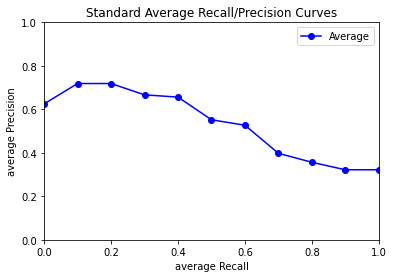

In [ ]:
import warnings
warnings.filterwarnings('ignore')
# !pip install prettytable
from prettytable import PrettyTable

# Plot table 
def plot_df_table(result):
  pt = PrettyTable()
  # Add columns to the PrettyTable
  pt.field_names = ["Query", "Recall@1~10", "Precision@1~10", "F1measure@1~10"]

  # Add rows from results to the table
  for index, row in result.iterrows():
    pt.add_row([row['Query'], row['Recall'], row['Precision'], row['F1measure']])
  print(pt)

  # Plot table 
def plot_avg_table(result):
  pt = PrettyTable()
  # Add columns to the PrettyTable
  pt.field_names = ['Query', 'Average Recall', 'Average Precision', 'Average F1measure']

  # Add rows from results to the table
  for index, row in result.iterrows():
    pt.add_row([index+1, row['Average Recall'], row['Average Precision'], row['Average F1measure']])
  print(pt)

# Define tuning parameters for weighthing schemes and SVD parameters
Xtrain = _prepare_data(reviews, 'tfidf', vocab)
trunc_SVD_model = TruncatedSVD(n_components=5)
approx_Xtrain = trunc_SVD_model.fit_transform(Xtrain)

re_ID = [[36164,58481,26246,2033,48779,34523,9726,56494,49525,45278,35694,41876,17309,11135,17273,11247],
         [57123,25299,55017,7432,2114,40871],
         [33251,17304,50019,27679,6158,22408,29722,36677,2780,17944,19944,31657,52867,49216],
         [40373,28648,37486,30640,2131,19852,2134,36585,26535,51474,21070,56330,53660,44126],
         [13373,17607,41459,54748,33571],
         [45860,46500,27474,43945,52837,12358,41319,39932,45146,50197,8341,52375],
         [209,28542,216,47345,11356,33632,38637,7110,6649,51356,44358,36165,943,37864],
         [642,10642,37794,45518,3494,735,10037,41872,28542,53409,56865,44489,44490]]


AllRecall = list()
AllPrecision = list()
AllF1measure = list()
_y_axis_lsi_tf = list()
_y_axis_lsi_tfidf = list()

# Create a figure with subplots
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
fig.tight_layout(pad=5.0)
axes = axes.ravel()

# Create an empty DataFrame to store results
results_df = pd.DataFrame(columns=['Query', 'Recall', 'Precision', 'F1measure'])

# loop queries
j = 0
for query in querys:
  # retrieval
  encoded_query = _preprocess_query(query, 'tfidf', vocab)
  transformed_query = trunc_SVD_model.transform(encoded_query)
  similarities = cosine_similarity(approx_Xtrain, transformed_query)

  # rank the index
  indexes = np.argsort(similarities.flat)[::-1]
  doc_id = [data.iloc[indexes[i]]['ID'] for i in range(len(indexes))]

  # Mark the relevant index
  re_mark = []
  for i in range(len(indexes)):
    if (doc_id[i]) in re_ID[j]:
      re_mark.append(1)
    else:
      re_mark.append(0)
  # print(re_mark)

  # compute Recall, Precision, F1-measure
  Recall, Precision, F1measure = compute_R_P_F1(re_mark=re_mark, QuRe_ID=re_ID[j])

  # Save the results in the DataFrame
  results_df.loc[j] = [f"Query{j+1}", np.around(Recall[:10], 2), np.around(Precision[:10], 2), np.around(F1measure[:10], 2)]
  # save
  AllRecall.append(Recall)
  AllPrecision.append(Precision)
  AllF1measure.append(F1measure)

  # Plot R/P curve in the subplot
  x_axis = np.linspace(0, 1, 11)
  y_axis = compute_RP_yaxis(Precision=Precision, Recall=Recall)
  _y_axis_lsi_tfidf.append(y_axis)
  axes[j].plot(x_axis, y_axis, '-bo', color="purple", label="Query%d" % (j + 1))
  axes[j].set_xlim(0, 1)
  axes[j].set_ylim(0, 1)
  axes[j].set_xlabel('Recall')
  axes[j].set_ylabel('Precision')
  axes[j].set_title(f'Standard R/P Curves for Query {j + 1}')
  axes[j].legend()

  j += 1

# Print the results in a formatted table
print("\nResults for top n docs returned for each query:")
plot_df_table(results_df)

# Show the subplots
plt.show()

# print(results_df)

# compute average Recall, average Precision, average F1-measure
AllRecall = np.array(AllRecall)
AllPrecision = np.array(AllPrecision)
AllF1measure = np.array(AllF1measure)
AveRecall = (AllRecall[0] + AllRecall[1] + AllRecall[2] + AllRecall[3] + AllRecall[4] + AllRecall[5] + AllRecall[6] + AllRecall[7])/8
AvePrecision = (AllPrecision[0] + AllPrecision[1]+AllPrecision[2] + AllPrecision[3]+AllPrecision[4] + AllPrecision[5] + AllPrecision[6] + AllPrecision[7])/8
AveF1measure = (AllF1measure[0] + AllF1measure[1]+AllF1measure[2] + AllF1measure[3]+AllF1measure[4] + AllF1measure[5] + AllF1measure[6] + AllF1measure[7])/8

# Create a DataFrame for average results
avg_results_df = pd.DataFrame({'Average Recall': np.around(AveRecall[10:], 2),
                                'Average Precision': np.around(AvePrecision[10:], 2),
                                'Average F1measure': np.around(AveF1measure[10:], 2)})

plot_avg_table(avg_results_df.iloc[:10])

# Plot average R/P curve
x_axis = np.linspace(0, 1, 11)
y_axis_tfidf = compute_RP_yaxis(Precision=AvePrecision, Recall=AveRecall)
plt.plot(x_axis, y_axis_tfidf, '-bo', color="blue", label="Average")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('average Recall')
plt.ylabel('average Precision')
plt.title('Standard Average Recall/Precision Curves')
plt.legend()
plt.show()

LSI_tfidf_avg = y_axis_tfidf

##### Evaluating each query by comparing their metrics against the Average


Query1: The ring is a great gift. My friend loves it
Recall:  [0.06 0.12 0.12 0.19 0.25 0.31 0.38 0.44 0.5  0.5 ]
Precision:  [1.   1.   0.67 0.75 0.8  0.83 0.86 0.88 0.89 0.8 ]
F1measure:  [0.12 0.22 0.21 0.3  0.38 0.45 0.52 0.58 0.64 0.62]

Query2: horrible bad quality bracelet
Recall:  [0.   0.   0.   0.17 0.17 0.17 0.17 0.17 0.17 0.17]
Precision:  [0.   0.   0.   0.25 0.2  0.17 0.14 0.12 0.11 0.1 ]
F1measure:  [0.   0.   0.   0.2  0.18 0.17 0.15 0.14 0.13 0.12]

Query3: arrived promptly and happy with the seller
Recall:  [0.   0.07 0.14 0.21 0.29 0.29 0.29 0.29 0.29 0.29]
Precision:  [0.   0.5  0.67 0.75 0.8  0.67 0.57 0.5  0.44 0.4 ]
F1measure:  [0.   0.12 0.24 0.33 0.42 0.4  0.38 0.36 0.35 0.33]

Query4: wear it with casual wear
Recall:  [0.07 0.07 0.14 0.21 0.29 0.36 0.43 0.5  0.5  0.5 ]
Precision:  [1.   0.5  0.67 0.75 0.8  0.83 0.86 0.88 0.78 0.7 ]
F1measure:  [0.13 0.12 0.24 0.33 0.42 0.5  0.57 0.64 0.61 0.58]

Query5: i expected better quality. i will return this item
Recal

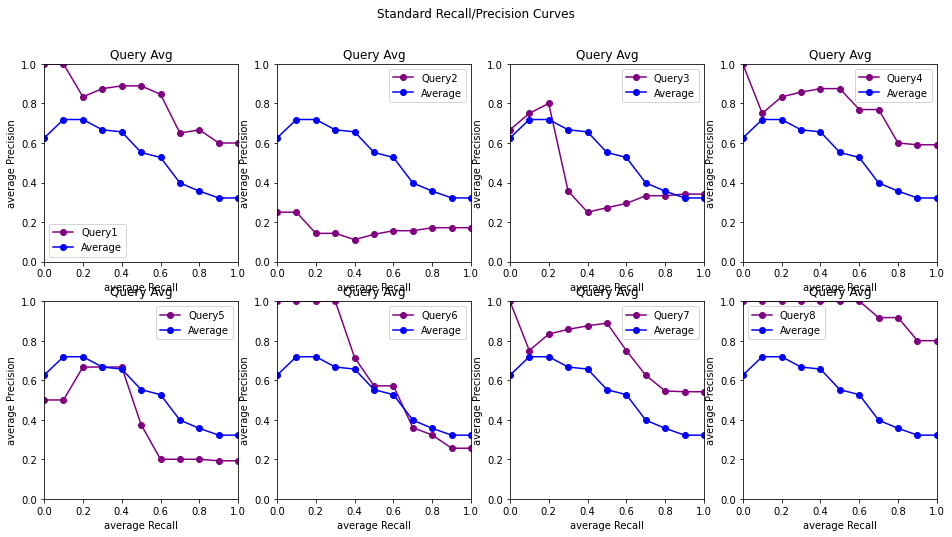

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Initialize the figure
fig, axs = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Standard Recall/Precision Curves')

re_ID = [[36164,58481,26246,2033,48779,34523,9726,56494,49525,45278,35694,41876,17309,11135,17273,11247],
         [57123,25299,55017,7432,2114,40871],
         [33251,17304,50019,27679,6158,22408,29722,36677,2780,17944,19944,31657,52867,49216],
         [40373,28648,37486,30640,2131,19852,2134,36585,26535,51474,21070,56330,53660,44126],
         [13373,17607,41459,54748,33571],
         [45860,46500,27474,43945,52837,12358,41319,39932,45146,50197,8341,52375],
         [209,28542,216,47345,11356,33632,38637,7110,6649,51356,44358,36165,943,37864],
         [642,10642,37794,45518,3494,735,10037,41872,28542,53409,56865,44489,44490]]

AllRecall = list()
AllPrecision = list()
AllF1measure = list()
_y_axis_lsi_tf = list()
_y_axis_lsi_tfidf = list()


# Loop queries
for j, query in enumerate(querys):
  # Retrieval
  encoded_query = _preprocess_query(query, 'tfidf', vocab)
  transformed_query = trunc_SVD_model.transform(encoded_query)
  similarities = cosine_similarity(approx_Xtrain, transformed_query)

  # Rank the index
  indexes = np.argsort(similarities.flat)[::-1]
  doc_id = [data.iloc[indexes[i]]['ID'] for i in range(len(indexes))]

  # Mark the relevant index
  re_mark = []
  for i in range(len(indexes)):
    if doc_id[i] in re_ID[j]:
      re_mark.append(1)
    else:
      re_mark.append(0)

  # Compute Recall, Precision, F1-measure
  Recall, Precision, F1measure = compute_R_P_F1(re_mark=re_mark, QuRe_ID=re_ID[j])
  
  print('\n' + 'Query%d: '%(j+1) + query)
  print("Recall: ", np.around(Recall[:10],2))
  print("Precision: ", np.around(Precision[:10],2))
  print("F1measure: ", np.around(F1measure[:10],2))

  # Save
  AllRecall.append(Recall)
  AllPrecision.append(Precision)
  AllF1measure.append(F1measure)

   # Plot R/P curve
  x_axis = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

  # Compute y-axis
  Recall = np.array(Recall)
  Precision = np.array(Precision)
  y_axis = compute_RP_yaxis(Precision=Precision, Recall=Recall)

  # Save y-axis for averaging later
  _y_axis_lsi_tfidf.append(y_axis)

  # Plot R/P curve in subplot
  row = j // 4
  col = j % 4
  axs[row, col].plot(x_axis, y_axis, '-bo', color="purple", label="Query%d"%(j+1))
  axs[row, col].set_xlim(0, 1)
  axs[row, col].set_ylim(0, 1)
  axs[row, col].set_xlabel('Recall')
  axs[row, col].set_ylabel('Precision')
  axs[row, col].set_title('Query %d'%(j+1))
  axs[row, col].legend()
  
# Compute average Recall, average Precision, average F1-measure
AllRecall = np.array(AllRecall)
AllPrecision = np.array(AllPrecision)
AllF1measure = np.array(AllF1measure)
AveRecall = np.mean(AllRecall, axis=0)
AvePrecision = np.mean(AllPrecision, axis=0)
AveF1measure = np.mean(AllF1measure, axis=0)

# Plot average R/P curve
y_axis = compute_RP_yaxis(Precision=AvePrecision, Recall=AveRecall)
for i in range(2):
  for j in range(4):
    axs[i, j].plot(x_axis, y_axis, '-bo', color="blue", label="Average")
    axs[i, j].set_xlim(0, 1)
    axs[i, j].set_ylim(0, 1)
    axs[i, j].set_xlabel('average Recall')
    axs[i, j].set_ylabel('average Precision')
    axs[i, j].set_title('Query Avg')
    axs[i, j].legend()
    
plt.show()



#### Tune Tf (Sublinear) and SVD dimension of 3 


Results for top n docs returned for each query:
+--------+-----------------------------------------------------+-----------------------------------------------------+-----------------------------------------------------+
| Query  |                     Recall@1~10                     |                    Precision@1~10                   |                    F1measure@1~10                   |
+--------+-----------------------------------------------------+-----------------------------------------------------+-----------------------------------------------------+
| Query1 |           [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]           |           [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]           |           [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]           |
| Query2 |           [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]           |           [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]           |           [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]           |
| Query3 |           [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]           |           [0. 0. 0. 0

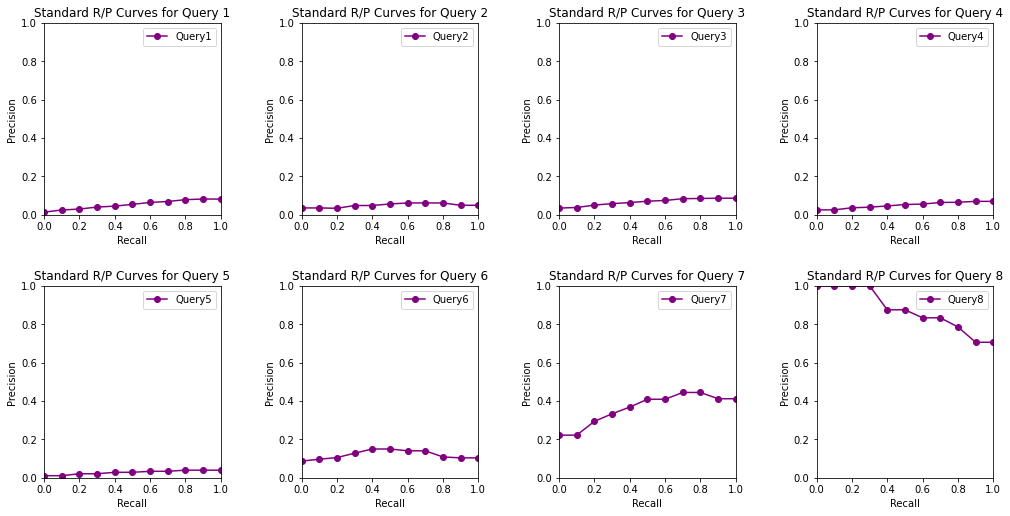

+-------+----------------+-------------------+-------------------+
| Query | Average Recall | Average Precision | Average F1measure |
+-------+----------------+-------------------+-------------------+
|   1   |      0.1       |        0.12       |        0.11       |
|   2   |      0.11      |        0.12       |        0.12       |
|   3   |      0.12      |        0.12       |        0.12       |
|   4   |      0.13      |        0.12       |        0.13       |
|   5   |      0.14      |        0.12       |        0.13       |
|   6   |      0.15      |        0.12       |        0.14       |
|   7   |      0.17      |        0.13       |        0.15       |
|   8   |      0.18      |        0.13       |        0.15       |
|   9   |      0.19      |        0.13       |        0.15       |
|   10  |      0.19      |        0.12       |        0.15       |
+-------+----------------+-------------------+-------------------+


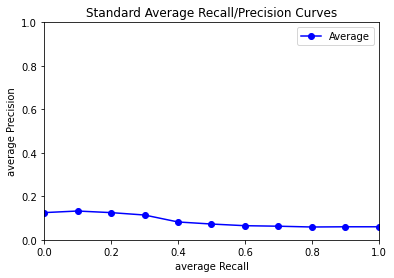

In [ ]:
# Define tuning parameters for weighthing schemes and SVD parameters
Xtrain_tf = _prepare_data(reviews, 'tf', vocab)
trunc_SVD_model_tf = TruncatedSVD(n_components=3)
approx_Xtrain_tf = trunc_SVD_model_tf.fit_transform(Xtrain)

re_ID = [[36164,58481,26246,2033,48779,34523,9726,56494,49525,45278,35694,41876,17309,11135,17273,11247],
         [57123,25299,55017,7432,2114,40871],
         [33251,17304,50019,27679,6158,22408,29722,36677,2780,17944,19944,31657,52867,49216],
         [40373,28648,37486,30640,2131,19852,2134,36585,26535,51474,21070,56330,53660,44126],
         [13373,17607,41459,54748,33571],
         [45860,46500,27474,43945,52837,12358,41319,39932,45146,50197,8341,52375],
         [209,28542,216,47345,11356,33632,38637,7110,6649,51356,44358,36165,943,37864],
         [642,10642,37794,45518,3494,735,10037,41872,28542,53409,56865,44489,44490]]


AllRecall = list()
AllPrecision = list()
AllF1measure = list()
_y_axis_lsi_tf = list()


# Create a figure with subplots
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
fig.tight_layout(pad=5.0)
axes = axes.ravel()

# Create an empty DataFrame to store results
results_df = pd.DataFrame(columns=['Query', 'Recall', 'Precision', 'F1measure'])

# loop queries
j = 0
for query in querys:
  # retrieval
  encoded_query_tf = _preprocess_query(query, 'tf', vocab)
  transformed_query_tf = trunc_SVD_model_tf.transform(encoded_query)
  similarities_tf = cosine_similarity(approx_Xtrain_tf, transformed_query_tf)

  # rank the index
  indexes_tf = np.argsort(similarities_tf.flat)[::-1]
  doc_id = [data.iloc[indexes_tf[i]]['ID'] for i in range(len(indexes_tf))]

  # Mark the relevant index
  re_mark = []
  for i in range(len(indexes_tf)):
    if (doc_id[i]) in re_ID[j]:
      re_mark.append(1)
    else:
      re_mark.append(0)
  # print(re_mark)

  # compute Recall, Precision, F1-measure
  Recall_tf, Precision_tf, F1measure_tf = compute_R_P_F1(re_mark=re_mark, QuRe_ID=re_ID[j])

  # Save the results in the DataFrame
  results_df.loc[j] = [f"Query{j+1}", np.around(Recall_tf[:10], 2), np.around(Precision_tf[:10], 2), np.around(F1measure_tf[:10], 2)]
  # save
  AllRecall.append(Recall_tf)
  AllPrecision.append(Precision_tf)
  AllF1measure.append(F1measure_tf)

  # Plot R/P curve in the subplot
  x_axis = np.linspace(0, 1, 11)
  y_axis = compute_RP_yaxis(Precision=Precision_tf, Recall=Recall_tf)
  _y_axis_lsi_tf.append(y_axis)
  axes[j].plot(x_axis, y_axis, '-bo', color="purple", label="Query%d" % (j + 1))
  axes[j].set_xlim(0, 1)
  axes[j].set_ylim(0, 1)
  axes[j].set_xlabel('Recall')
  axes[j].set_ylabel('Precision')
  axes[j].set_title(f'Standard R/P Curves for Query {j + 1}')
  axes[j].legend()

  j += 1

# Print the results in a formatted table
print("\nResults for top n docs returned for each query:")
plot_df_table(results_df)

# Show the subplots
plt.show()

# print(results_df)

# compute average Recall, average Precision, average F1-measure
AllRecall_tf = np.array(AllRecall)
AllPrecision_tf = np.array(AllPrecision)
AllF1measure_tf = np.array(AllF1measure)
AveRecall_tf = (AllRecall_tf[0] + AllRecall_tf[1] + AllRecall_tf[2] + AllRecall_tf[3] + AllRecall_tf[4] + AllRecall_tf[5] + AllRecall_tf[6] + AllRecall_tf[7])/8
AvePrecision_tf = (AllPrecision_tf[0] + AllPrecision_tf[1]+AllPrecision_tf[2] + AllPrecision_tf[3]+AllPrecision_tf[4] + AllPrecision_tf[5] + AllPrecision_tf[6] + AllPrecision_tf[7])/8
AveF1measure_tf = (AllF1measure_tf[0] + AllF1measure_tf[1]+AllF1measure_tf[2] + AllF1measure_tf[3]+AllF1measure_tf[4] + AllF1measure_tf[5] + AllF1measure_tf[6] + AllF1measure_tf[7])/8

# Create a DataFrame for average results
avg_results_tf = pd.DataFrame({'Average Recall': np.around(AveRecall_tf[10:], 2),
                                'Average Precision': np.around(AvePrecision_tf[10:], 2),
                                'Average F1measure': np.around(AveF1measure_tf[10:], 2)})

plot_avg_table(avg_results_tf.iloc[:10])

# Plot average R/P curve
x_axis = np.linspace(0, 1, 11)
y_axis_tf = compute_RP_yaxis(Precision=AvePrecision_tf, Recall=AveRecall_tf)
plt.plot(x_axis, y_axis_tf, '-bo', color="blue", label="Average")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('average Recall')
plt.ylabel('average Precision')
plt.title('Standard Average Recall/Precision Curves')
plt.legend()
plt.show()

LSI_tf_avg = y_axis_tf

##### Comparing TF vs TFIDF

The TFIDF retrieves a higher proportion of relevant documents while maintaining a higher precision, indicating a better recall-precision balance. The TF retrieval model, on the other hand, struggles to find relevant documents and has a higher rate of false positives. TFIDF is thus a more effective and accurate NLP LSI retrieval system than TF.

In [ ]:
from prettytable import PrettyTable

def plot_avg_table(df1, df2):
    # Print the average results in a formatted table
    print("\nAverage Recall, average Precision, average F1-measure:")

    # Create a PrettyTable for average results
    avg_pt = PrettyTable()

    # Add columns to the PrettyTable
    avg_pt.field_names = ["Rank", "TF-IDF Recall", "TF-IDF Precision", "TF-IDF F1measure",
                          "TF Recall", "TF Precision", "TF F1measure"]

    # Add rows from both DataFrames to the PrettyTable
    for index, (row1, row2) in enumerate(zip(df1.iterrows(), df2.iterrows())):
        _, row1 = row1
        _, row2 = row2
        avg_pt.add_row([index + 1,
                        row1['Average Recall'], row1['Average Precision'], row1['Average F1measure'],
                        row2['Average Recall'], row2['Average Precision'], row2['Average F1measure']])

    # Print the PrettyTable for average results
    print(avg_pt)

# Call the function with the top 10 rows of the DataFrames
plot_avg_table(avg_results_df.iloc[:10], avg_results_tf.iloc[:10])



Average Recall, average Precision, average F1-measure:
+------+---------------+------------------+------------------+-----------+--------------+--------------+
| Rank | TF-IDF Recall | TF-IDF Precision | TF-IDF F1measure | TF Recall | TF Precision | TF F1measure |
+------+---------------+------------------+------------------+-----------+--------------+--------------+
|  1   |      0.49     |       0.55       |       0.5        |    0.1    |     0.12     |     0.11     |
|  2   |      0.54     |       0.55       |       0.53       |    0.11   |     0.12     |     0.12     |
|  3   |      0.57     |       0.54       |       0.54       |    0.12   |     0.12     |     0.12     |
|  4   |      0.61     |       0.53       |       0.55       |    0.13   |     0.12     |     0.13     |
|  5   |      0.62     |       0.51       |       0.55       |    0.14   |     0.12     |     0.13     |
|  6   |      0.63     |       0.48       |       0.54       |    0.15   |     0.12     |     0.14     |



---



---



# 3 - Neural Information retrieval

Approach taken for Neural Information Retreival (NIR)

Overall, the cosine similarity approach to NIR is based on the ability of word embedding techniques to capture semantic relationships between words and the cosine similarity measure to compare query and document embeddings. This method has yielded promising results in improving the accuracy of traditional IR models.

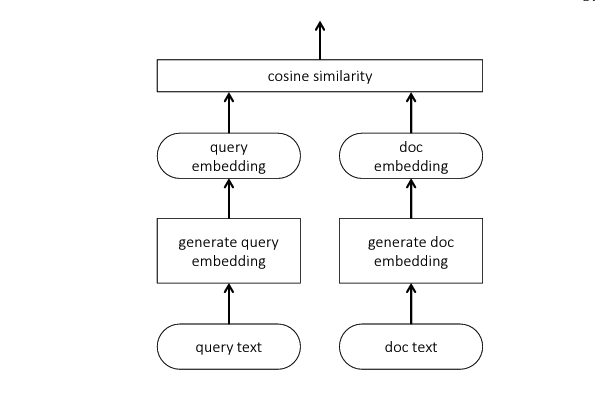

Approach employed involved encoding the query and document text into vector representations, computing their cosine similarity, ranking the documents based on their scores, and evaluating the model's accuracy using metrics such as precision, recall, and F1 score using BERT. 



## 3a - Develop a neural retrieval model and compare with LSI model

In [ ]:
# load all docs in a directory
def __process_query(queries, vocab):
	lines = list()
	# walk through all files in the folder
	for doc in queries:
		# print(len(doc))
		line = doc_to_line(doc, vocab)
		# add to list
		lines.append(line)
	return lines

train_docs = reviews
query_docs = __process_query(querys, vocab)

train_docs = pd.Series(train_docs) 
query_docs = pd.Series(query_docs)

# print(train_docs.shape)
# print(test_docs.shape)

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Loading the Pre-trained BERT model
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
N = len(train_docs)

with torch.no_grad():
    # Tokenization
    tokenized = train_docs[0:N].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

    # padding
    max_len = 0
    q = 0
    for i in tokenized.values:
        
        # BERT only accept maximum 512 values
        if len(i) > 512:
            temp = tokenized.values[q]
            tokenized.values[q] = temp[:512]
            i = tokenized.values[q]
            print('too much tokenized.values for BERT, only 512 are taken')

        # print(len(i))
        if len(i) > max_len:
            max_len = len(i)
        q += 1

    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
    np.array(padded).shape

    # masking
    attention_mask = np.where(padded != 0, 1, 0)
    attention_mask.shape

    # run the model
    input_ids = torch.tensor(padded)  
    attention_mask = torch.tensor(attention_mask)

    print(input_ids.shape)

    last_hidden_states = model(input_ids, attention_mask=attention_mask)

    train_features = last_hidden_states[0][:,0,:].numpy()

print(len(train_features))  


torch.Size([200, 49])
200


In [ ]:
N2 = len(query_docs)

with torch.no_grad():
    # Tokenization
    tokenized = query_docs[0:N2].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

    # padding
    max_len = 0
    q = 0
    for i in tokenized.values:
        
        # BERT only accept maximum 512 values
        if len(i) > 512:
            temp = tokenized.values[q]
            tokenized.values[q] = temp[:512]
            i = tokenized.values[q]
            print('too much tokenized.values for BERT, only 512 are taken')

        # print(len(i))
        if len(i) > max_len:
            max_len = len(i)
        q += 1

    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
    np.array(padded).shape
    # masking
    attention_mask = np.where(padded != 0, 1, 0)
    attention_mask.shape
    # run the model
    input_ids = torch.tensor(padded)  
    attention_mask = torch.tensor(attention_mask)

    print(input_ids.shape)

    last_hidden_states = model(input_ids, attention_mask=attention_mask)

    query_features = last_hidden_states[0][:,0,:].numpy()

print(len(query_features))  

torch.Size([8, 9])
8



Query1: braclet looked just like its picture and is nice quality sterling silver.
Top 1 result: ID48779  thing love got ring rings gift
Top 2 result: ID48216  imagine got ring birthday adoring woman love
Top 3 result: ID45203  imagine got ring birthday adoring woman love
Top 4 result: ID41876  gift ring birthday bought friends loved
Top 5 result: ID58481  great high gift ring loves quality cheap wife
Top 6 result: ID10535  love know like ring one wanted rings gorgeous beyond
Top 7 result: ID28250  love know like ring one wanted rings gorgeous beyond
Top 8 result: ID17442  addiction thank eve ring beautiful sending daughter wonderful
Top 9 result: ID37896  great ring around wish comfortable way
Top 10 result: ID6522  suggest ring every collection jewelry love
Recall@1~10:  [0.06 0.06 0.06 0.12 0.19 0.19 0.19 0.19 0.19 0.19]
Precision@1~10:  [1.   0.5  0.33 0.5  0.6  0.5  0.43 0.38 0.33 0.3 ]
F1measure@1~10:  [0.12 0.11 0.11 0.2  0.29 0.27 0.26 0.25 0.24 0.23]


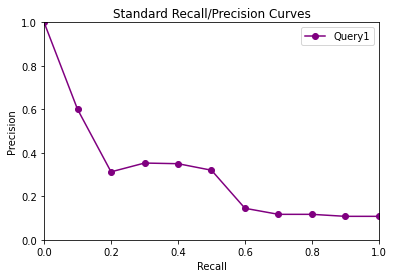


Query2: braclet looked just like its picture and is nice quality sterling silver.
Top 1 result: ID19944  purchase use pleased shipping
Top 2 result: ID2134  wearing
Top 3 result: ID52663  see wear ring comfortable quite please
Top 4 result: ID9050  ring easily pretty metal enough
Top 5 result: ID57123  quality definitely worth disappointed bracelet appearance even close
Top 6 result: ID11247  price love always wanted
Top 7 result: ID11087  wear favorite wanted mine
Top 8 result: ID19852  everyday good wear
Top 9 result: ID52867  perfect shipping arrived condition product order
Top 10 result: ID45548  high item small quality attractive
Recall@1~10:  [0.   0.   0.   0.   0.17 0.17 0.17 0.17 0.17 0.17]
Precision@1~10:  [0.   0.   0.   0.   0.2  0.17 0.14 0.12 0.11 0.1 ]
F1measure@1~10:  [0.   0.   0.   0.   0.18 0.17 0.15 0.14 0.13 0.12]


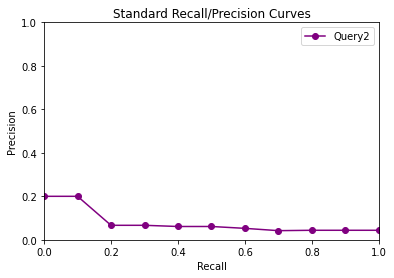


Query3: braclet looked just like its picture and is nice quality sterling silver.
Top 1 result: ID37896  great ring around wish comfortable way
Top 2 result: ID11247  price love always wanted
Top 3 result: ID19944  purchase use pleased shipping
Top 4 result: ID30926  timely recommend looks ring manner garnet would
Top 5 result: ID57123  quality definitely worth disappointed bracelet appearance even close
Top 6 result: ID50197  look beautiful smooth
Top 7 result: ID11087  wear favorite wanted mine
Top 8 result: ID3494  like looks picture nice
Top 9 result: ID52663  see wear ring comfortable quite please
Top 10 result: ID3865  sparkle pretty looking dainty
Recall@1~10:  [0.   0.   0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07]
Precision@1~10:  [0.   0.   0.33 0.25 0.2  0.17 0.14 0.12 0.11 0.1 ]
F1measure@1~10:  [0.   0.   0.12 0.11 0.11 0.1  0.1  0.09 0.09 0.08]


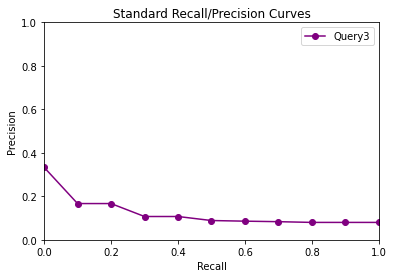


Query4: braclet looked just like its picture and is nice quality sterling silver.
Top 1 result: ID19852  everyday good wear
Top 2 result: ID44126  light stones catch style comfortable wear
Top 3 result: ID37486  wear work casual nt pendant going
Top 4 result: ID2134  wearing
Top 5 result: ID30640  enough wear perfect suit colors detail nice
Top 6 result: ID52663  see wear ring comfortable quite please
Top 7 result: ID11087  wear favorite wanted mine
Top 8 result: ID44135  finger index great ring fits comfortable awesome wear
Top 9 result: ID50640  finger index great ring fits comfortable awesome wear
Top 10 result: ID45548  high item small quality attractive
Recall@1~10:  [0.07 0.14 0.21 0.29 0.36 0.36 0.36 0.36 0.36 0.36]
Precision@1~10:  [1.   1.   1.   1.   1.   0.83 0.71 0.62 0.56 0.5 ]
F1measure@1~10:  [0.13 0.25 0.35 0.44 0.53 0.5  0.48 0.45 0.43 0.42]


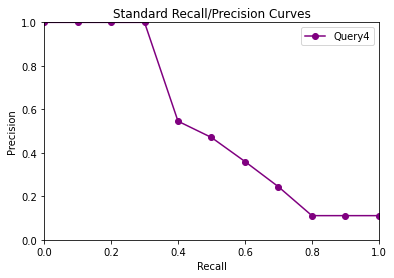


Query5: braclet looked just like its picture and is nice quality sterling silver.
Top 1 result: ID13373  quality pictured seller item poor
Top 2 result: ID1816  look recommend item would quality
Top 3 result: ID45548  high item small quality attractive
Top 4 result: ID52867  perfect shipping arrived condition product order
Top 5 result: ID17944  expected item product order came nice
Top 6 result: ID17607  clearly expecting quality description returned seemed item poor product
Top 7 result: ID19852  everyday good wear
Top 8 result: ID38305  high see quality fan charm item would
Top 9 result: ID50019  described easy smooth shipped pleased time purchase product earrings received
Top 10 result: ID8110  addiction quality family eve friends definately item pleased
Recall@1~10:  [0.2 0.2 0.2 0.2 0.2 0.4 0.4 0.4 0.4 0.4]
Precision@1~10:  [1.   0.5  0.33 0.25 0.2  0.33 0.29 0.25 0.22 0.2 ]
F1measure@1~10:  [0.33 0.29 0.25 0.22 0.2  0.36 0.33 0.31 0.29 0.27]


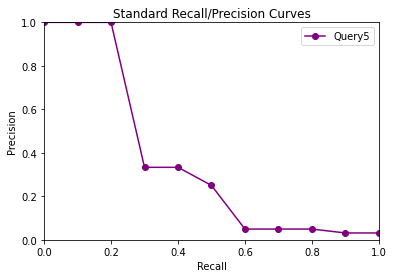


Query6: braclet looked just like its picture and is nice quality sterling silver.
Top 1 result: ID52375  bought looks pretty present color nice
Top 2 result: ID37794  look quality like light picture polished comfortable price good silver stones earrings
Top 3 result: ID41319  exactly looks hand pictured ring pretty beautiful stones color
Top 4 result: ID943  look looks life like ring looking real picture online man
Top 5 result: ID39932  looks heart dainty beautiful price colors amazing pendant absolutely
Top 6 result: ID25299  perfect necklace bracelet true nice quality
Top 7 result: ID2131  hand wear work looking wanted wearing gold right piece
Top 8 result: ID17166  necklace money look well think yet pretty delicate worth beautiful simple
Top 9 result: ID53693  get money bought date ring definitely looking old engagement beautiful price
Top 10 result: ID25378  many love different ring engagement wanted rings looked perfect buying wearing everything fell
Recall@1~10:  [0.08 0.08 0.1

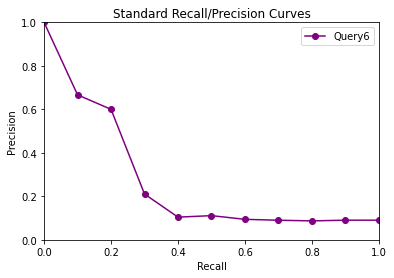


Query7: braclet looked just like its picture and is nice quality sterling silver.
Top 1 result: ID3494  like looks picture nice
Top 2 result: ID3865  sparkle pretty looking dainty
Top 3 result: ID50197  look beautiful smooth
Top 4 result: ID642  like looked sterling silver nice quality picture
Top 5 result: ID9050  ring easily pretty metal enough
Top 6 result: ID57123  quality definitely worth disappointed bracelet appearance even close
Top 7 result: ID11087  wear favorite wanted mine
Top 8 result: ID48779  thing love got ring rings gift
Top 9 result: ID47345  little nothing like picture looked nt diamonds bit product
Top 10 result: ID36585  every forward looking eye wearing wedding sparkle catch
Recall@1~10:  [0.   0.   0.   0.   0.   0.   0.   0.   0.07 0.07]
Precision@1~10:  [0.   0.   0.   0.   0.   0.   0.   0.   0.11 0.1 ]
F1measure@1~10:  [0.   0.   0.   0.   0.   0.   0.   0.   0.09 0.08]


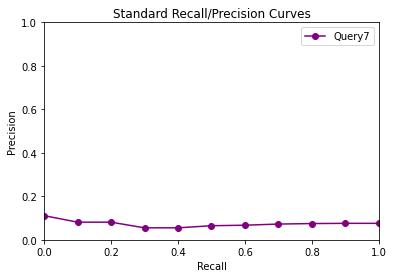


Query8: braclet looked just like its picture and is nice quality sterling silver.
Top 1 result: ID642  like looked sterling silver nice quality picture
Top 2 result: ID3494  like looks picture nice
Top 3 result: ID57123  quality definitely worth disappointed bracelet appearance even close
Top 4 result: ID10642  like picture looked purple clear
Top 5 result: ID47345  little nothing like picture looked nt diamonds bit product
Top 6 result: ID52375  bought looks pretty present color nice
Top 7 result: ID32674  much quality item could wonderful ever surprise hoped
Top 8 result: ID9050  ring easily pretty metal enough
Top 9 result: ID36677  exactly pictures looks like worth item pleased time fast shipping days order
Top 10 result: ID2185  recommend small looks like toy ring way want would nice
Recall@1~10:  [0.08 0.15 0.15 0.23 0.23 0.23 0.23 0.23 0.23 0.23]
Precision@1~10:  [1.   1.   0.67 0.75 0.6  0.5  0.43 0.38 0.33 0.3 ]
F1measure@1~10:  [0.14 0.27 0.25 0.35 0.33 0.32 0.3  0.29 0.27 0

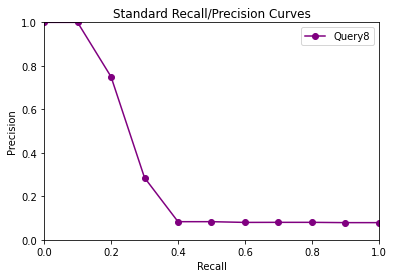


Average Recall, average Precision, average F1-measure: 
average Recall@1~10:  [0.06 0.08 0.11 0.13 0.18 0.21 0.21 0.21 0.22 0.22]
average Precision@1~10:  [0.62 0.44 0.42 0.41 0.43 0.38 0.32 0.28 0.26 0.24]
average F1measure@1~10:  [0.11 0.13 0.17 0.2  0.25 0.26 0.24 0.23 0.23 0.22]


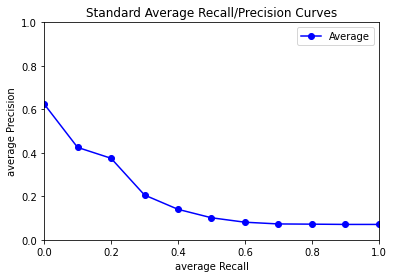

In [ ]:
Top_n_rankings = 10
BERT_AllRecall = list()
BERT_AllPrecision = list()
BERT_AllF1measure = list()
_y_axis = list()
_avg_y_axis = list()
j = 0

for key,value in enumerate(querys):
  Q_features = query_features[key,:]
  Q_features = Q_features.reshape(1,-1)
  BERT_similarity_scores = cosine_similarity(train_features,Q_features)
  # ###
  BERT_idx = np.argsort(BERT_similarity_scores.flat)[::-1]
  doc_id = [data.iloc[BERT_idx[i]]["ID"] for i in range(len(BERT_idx))]
  # #####
  BERT_doc_idx = []
  for i in range(len(BERT_idx)):
    BERT_doc_idx.append(doc_id[i])
  # ###
  BERT_re_mark = []
  for i in range(len(BERT_idx)):
    if (BERT_doc_idx[i]) in re_ID[j]:
      BERT_re_mark.append(1)
    else:
      BERT_re_mark.append(0)

  # compute Recall, Precision, F1-measure
  BERT_Recall, BERT_Precision, BERT_F1measure = compute_R_P_F1(re_mark=BERT_re_mark, QuRe_ID=re_ID[j])
  
  print('\n' + 'Query%d: '%(j+1) + query)
  for x in range(Top_n_rankings):
    print("Top " + str(x+1) + ' result: ID%d '%(BERT_doc_idx[x]), reviews[BERT_idx[x]])
  BERT_Recall = np.array(BERT_Recall)
  BERT_Precision = np.array(BERT_Precision)
  BERT_F1measure = np.array(BERT_F1measure)
  # print(re_mark)
  print("Recall@1~10: ", np.around(BERT_Recall[:10],2))
  print("Precision@1~10: ", np.around(BERT_Precision[:10],2))
  print("F1measure@1~10: ", np.around(BERT_F1measure[:10],2))

  # save
  BERT_AllRecall.append(BERT_Recall)
  BERT_AllPrecision.append(BERT_Precision)
  BERT_AllF1measure.append(BERT_F1measure)

  # plot R/P curve
  x_axis = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
  y_axis = compute_RP_yaxis(Precision=BERT_Precision, Recall=BERT_Recall)
  _y_axis.append(y_axis)
  plt.plot(x_axis, y_axis, '-bo', color="purple", label="Query%d"%(j+1))
  plt.xlim(0, 1)
  plt.ylim(0, 1)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Standard Recall/Precision Curves')
  plt.legend()
  plt.show()

  j += 1

# compute average Recall, average Precision, average F1-measure
BERT_AllRecall = np.array(BERT_AllRecall)
BERT_AllPrecision = np.array(BERT_AllPrecision)
BERT_AllF1measure = np.array(BERT_AllF1measure)
#calculate the average metrices for 8 queries
BERT_AveRecall = (BERT_AllRecall[0] + BERT_AllRecall[1] + BERT_AllRecall[2] + BERT_AllRecall[3] + BERT_AllRecall[4] + BERT_AllRecall[5] + BERT_AllRecall[6] + BERT_AllRecall[7])/8
BERT_AvePrecision = (BERT_AllPrecision[0] + BERT_AllPrecision[1] + BERT_AllPrecision[2] + BERT_AllPrecision[3] + BERT_AllPrecision[4] + BERT_AllPrecision[5] + BERT_AllPrecision[6] + BERT_AllPrecision[7])/8
BERT_AveF1measure = (BERT_AllF1measure[0] + BERT_AllF1measure[1] + BERT_AllF1measure[2] + BERT_AllF1measure[3] + BERT_AllF1measure[4] + BERT_AllF1measure[5] + BERT_AllF1measure[6] + BERT_AllF1measure[7])/8

print("\nAverage Recall, average Precision, average F1-measure: ")
print("average Recall@1~10: ", np.around(BERT_AveRecall[:10],2))
print("average Precision@1~10: ", np.around(BERT_AvePrecision[:10],2))
print("average F1measure@1~10: ", np.around(BERT_AveF1measure[:10],2))

# plot average R/P curve
x_axis = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
y_axis = compute_RP_yaxis(Precision=BERT_AvePrecision, Recall=BERT_AveRecall)
plt.plot(x_axis, y_axis, '-bo', color="blue", label="Average")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('average Recall')
plt.ylabel('average Precision')
plt.title('Standard Average Recall/Precision Curves')
plt.legend()
plt.show()

BERT_y_axis_avg = y_axis

3a Comparisim of NIR & LSI


Query1: The ring is a great gift. My friend loves it

Query2: horrible bad quality bracelet

Query3: arrived promptly and happy with the seller

Query4: wear it with casual wear

Query5: i expected better quality. i will return this item

Query6: looks beautiful. The design is pretty. pefect and color is light

Query7: This ring looks nothing like the picture. the diamonds are small and not very noticeable

Query8: braclet looked just like its picture and is nice quality sterling silver.


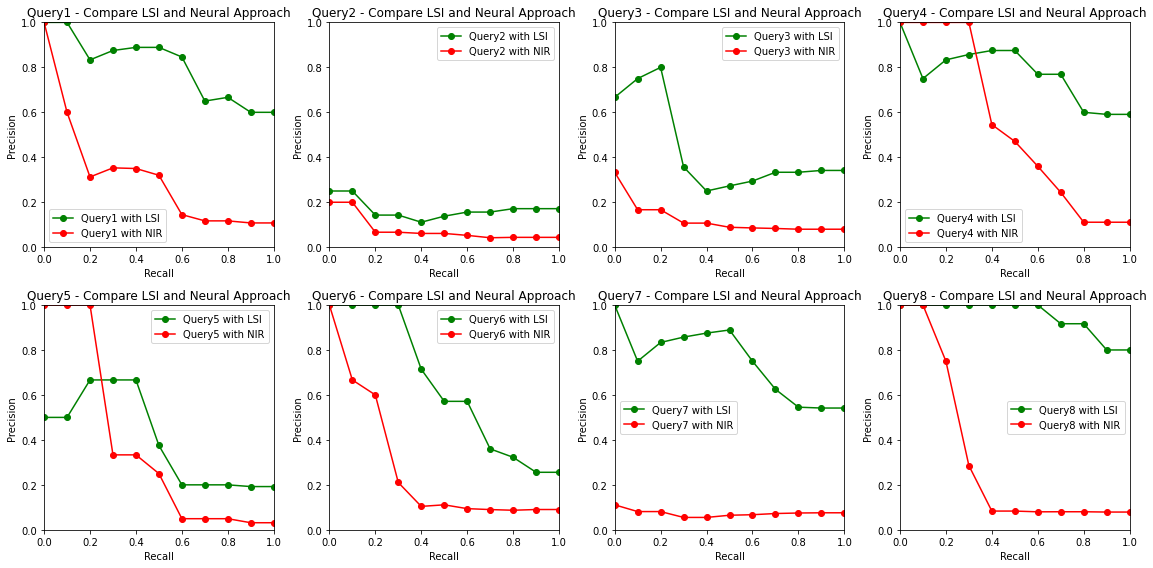

+------------------------------------------------------------------------------------------+---------------+------------+---------------+------------+
|                                          Query                                           | LSI Precision | LSI Recall | NIR Precision | NIR Recall |
+------------------------------------------------------------------------------------------+---------------+------------+---------------+------------+
|                       The ring is a great gift. My friend loves it                       |      0.89     |    0.5     |      0.32     |    0.5     |
|                              horrible bad quality bracelet                               |      0.14     |    0.5     |      0.06     |    0.5     |
|                        arrived promptly and happy with the seller                        |      0.27     |    0.5     |      0.09     |    0.5     |
|                                 wear it with casual wear                                 |  

In [ ]:
from prettytable import PrettyTable

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

table = PrettyTable()
table.field_names = ["Query", "LSI Precision", "LSI Recall", "NIR Precision", "NIR Recall"]

for key, (query, index) in enumerate(zip(querys, range(len(querys)))):
    # plot R/P curves for both methods(NIR and LSI)
    print('\n' + 'Query%d: '%(index+1) + query)
    x_axis = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    plot_LSI = _y_axis_lsi_tfidf[index]
    plot_NIR = _y_axis[index]
    row = key // 4
    col = key % 4
    ax = axs[row, col]
    ax.plot(x_axis, plot_LSI, '-bo', color="green", label="Query%d with LSI"%(index+1))
    ax.plot(x_axis, plot_NIR, '-bo', color="red", label="Query%d with NIR"%(index+1))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Query%d - Compare LSI and Neural Approach'%(index+1))
    ax.legend()

    # calculate R/P values
    LSI_precision = _y_axis_lsi_tfidf[index][5]
    LSI_recall = x_axis[5]
    NIR_precision = _y_axis[index][5]
    NIR_recall = x_axis[5]

    # add R/P values to the table
    table.add_row([query, round(LSI_precision, 2), round(LSI_recall, 2), round(NIR_precision, 2), round(NIR_recall, 2)])

plt.tight_layout()
plt.show()

print(table)

The LSI model achieves a better balance of recall and precision because it retrieves relevant documents more accurately, resulting in fewer false positives. NIR, on the other hand, retrieves relevant documents less accurately, resulting in a higher rate of false positives.

## 3b - An Interactive interface for users to type in their own query

In [ ]:
# Build funtion to convert queries to embedded representations using NIR
def build_nir_query_embedding(query, n):
  query_doc = pd.Series(query)
  with torch.no_grad():
      # Tokenization
      tokenized = query_doc[0:n].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

      # padding
      max_len = 0
      q = 0
      for i in tokenized.values:
          
          # BERT only accept maximum 512 values
          if len(i) > 512:
              temp = tokenized.values[q]
              tokenized.values[q] = temp[:512]
              i = tokenized.values[q]
              print('too much tokenized.values for BERT, only 512 are taken')

          # print(len(i))
          if len(i) > max_len:
              max_len = len(i)
          q += 1

      padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
      np.array(padded).shape
      # masking
      attention_mask = np.where(padded != 0, 1, 0)
      attention_mask.shape
      # run the model
      input_ids = torch.tensor(padded)  
      attention_mask = torch.tensor(attention_mask)

      last_hidden_states = model(input_ids, attention_mask=attention_mask)

      query_features = last_hidden_states[0][:,0,:].numpy()
      return query_features 

# Build funtion to convert queries to embedded representations using LSI
def build_lsi_query_embedding(query, n):
  encoded_query = preprocess_query(query, 'tfidf', vocab)
  # print(encoded_query.shape)
  transformed_query = trunc_SVD_model.transform(encoded_query)
  return transformed_query

In [ ]:
from prettytable import PrettyTable, ALL

def search_nir(query, n_results=5):
  # Get the query embedding using the BERT-based model
  embedding = build_nir_query_embedding(query, n_results)

  # Calculate the cosine similarity between the query embedding and the document embeddings
  similarity = cosine_similarity(train_features, embedding)

  # Get the indexes of the top n_results most similar documents sorted by similarity score
  indexes = np.argsort(similarity, axis=None)[::-1][:n_results]

  # Get the document IDs, texts, and similarity scores of the top n_results most similar documents
  d_id = [i for i in indexes]
  ndoc_id = [data.iloc[k]['ID'] for k in indexes]
  ndoc_text = [data.iloc[k]['Reviews'] for k in indexes]
  similarity_scores = [np.around(similarity[k], 4) for k in indexes]

  # Return the query IDs, document IDs, document texts, and similarity scores
  return d_id, ndoc_id, ndoc_text, similarity_scores

def print_search_results(d_id, ndoc_id, ndoc_text, similarity_scores):
  # Create a PrettyTable object to format the search results
  results = PrettyTable()

  # Set the field names and formatting options for the table
  results.field_names = ["Rank", "Doc ID", "Score", "Text"]
  results.hrules = ALL
  results.vrules = ALL
  results.align["Rank"] = "c"
  results.align["Doc ID"] = "l"
  results.align["Similarity Score"] = "c"
  results.align["Text"] = "l"
  results.float_format = ".4"

  # Add the query as the first row of the table
  results.add_row(["Query", "", "", query])

  # Add the top n_results most similar documents to the table
  for i in range(n_results):
    results.add_row([i+1, ndoc_id[i], similarity_scores[i],  ndoc_text[i]])

  # Print the formatted table
  print(results)

def search_lsi(query, n_results=5):
  # Get the query embedding using the LSI-based model
  lsi_embedding = build_lsi_query_embedding(query, n_results)
  # Calculate the cosine similarity between the query embedding and the document embeddings
  similarity = cosine_similarity(Xtrain, lsi_embedding)
  
  # indexes = np.argsort(similarities.flat)[-n_results:]
  # Get the indexes of the top n_results most similar documents sorted by similarity score
  indexes = np.argsort(similarity, axis=None)[::-1][:n_results]

  # Get the document IDs, texts, and similarity scores of the top n_results most similar documents
  d_id = [i for i in indexes]
  ndoc_id = [data.iloc[k]['ID'] for k in indexes]
  ndoc_text = [data.iloc[k]['Reviews'] for k in indexes]
  similarity_scores = [np.around(similarity[k], 4) for k in indexes]

  
  # print('_'*100)
  # print(f'Query: {query}')
  # print('='*100)
  # print(f"Top {n_results} documents retrieved:  {str(doc_id)}")
  # print('='*100)
  # for i in range(Top_n_reviews, 0, -1):
  #   print("Doc ID: " + str(indexes[-i]))
  #   # print("ID"+ str(data.iloc[indexes[i]]))
  #   print(reviews[indexes[-i]])
  #   print(docs[indexes[-i]])

  # Return the query IDs, document IDs, document texts, and similarity scores
  return d_id, ndoc_id, ndoc_text, similarity_scores

In [ ]:
n_results = 10 #@param {type:"slider", min:1, max:10, step:1}
# Get the query and rank from the user using input forms

In [ ]:
query = input("Enter your query:")

# n_results = int(input("Enter the number of results you want to retrieve:"))

_id, ndoc_id, doc_text, similarity = search_nir(query, n_results)
print_search_results(_id, doc_id, doc_text, similarity)


Enter your query:This stunning ring is an absolute showstopper! The craftsmanship is impeccable and the attention to detail is truly impressive. The design is both elegant and unique, and the sparkling stones catch the light beautifully. I have received so many compliments while wearing this ring and it has quickly become one of my favorite pieces of jewelry. I highly recommend it to anyone looking for a luxurious and eye-catching addition to their collection.
+-------+--------+----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|  Rank | Doc ID |  Score   | Text                     

##### Interactive Search Using LSI

In [ ]:
# _id_lsi, ndoc_id_lsi, doc_text_lsi, similarity_lsi = search_lsi(query, n_results)

#### Fetch top 10 for each query in the query list

In [ ]:
queries = ['The ring is a great gift. My friend loves it',
          'horrible bad quality bracelet',
          'arrived promptly and happy with the seller',
          'wear it with casual wear',
          'i expected better quality. i will return this item',
          'looks beautiful. The design is pretty. pefect and color is light',
          'This ring looks nothing like the picture. the diamonds are small and not very noticeable',
          'braclet looked just like its picture and is nice quality sterling silver.'
]
  # Build Corpus list for use in Text sumarization. This was done here because the installation of Summertime messes up my environment

corpus_list = list()

for index, query in enumerate(queries):
  query_id, query_doc_id, query_doc_text, query_similarity = search_nir(query, n_results)
  print('\n' + f"QUERY {index+1} - {query}")
  print_search_results(_id, doc_id, doc_text, similarity)
  corpus_list.append(query_doc_text)



QUERY 1 - The ring is a great gift. My friend loves it
+-------+--------+----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|  Rank | Doc ID |  Score   | Text                                                                                                                                                                                                                                 |
+-------+--------+----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Query |        |          | The ring is a great gift. My friend loves it                                                                                       

# 4 - Topic Modelling

In [ ]:
# %%capture
# !pip install bertopic

#### 4a - Top n search results clustered them into topics

In [ ]:
from bertopic import BERTopic
from umap import UMAP
# Process data into a list
def __process_data(queries, vocab):
	lines = list()
	# walk through all files in the folder
	for doc in queries:
		# print(len(doc))
		line = doc_to_line(doc, vocab)
		# add to list
		lines.append(line)
	return lines

topic_object = list()
def build_topic(docs, corpus, n_results=50):
  
  # Collect the texts from the search results and perform cleaning 
  cleaned_docs = __process_data(docs, vocab)
  topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
  topics, probs = topic_model.fit_transform(cleaned_docs)
  topic_object.append(topic_model)
  return topic_object

def build_topic2(docs, corpus, n_results=50):

  umap_model = UMAP(n_neighbors=10, 
                  n_components=7, 
                  min_dist=0.0, 
                  metric='cosine', 
                  random_state=42)
	
  # Collect the texts from the search results and perform cleaning 
  cleaned_docs = __process_data(docs, vocab)
  # topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
  topic_model = BERTopic(umap_model=umap_model, language="english")
  topics, probs = topic_model.fit_transform(cleaned_docs)
  topic_object.append(topic_model)
  return topic_object

In [ ]:
from bertopic import BERTopic


# # Fetch the desired number of results
# n_results = int(input("Enter the number of results you want to retrieve:"))

n_results = 65 #@param {type:"slider", min:50, max:200, step:5}
# Get the query and rank from the user using input forms
query = input("Enter your query to extract topics:")

# Perform Search and retrieve the top search results
_id, doc_id, docs, similarity = search_nir(query, n_results)

# Collect the texts from the search results
cleaned_docs = __process_data(docs, vocab)

# Built Topic Cluster
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(cleaned_docs)

print('\n' + '='*100)
print('Topics')
print('='*100)
topic_model.get_topic(0)  # Select the most frequent topic


Enter your query to extract topics:This stunning ring is an absolute showstopper! The craftsmanship is impeccable and the attention to detail is truly impressive. The design is both elegant and unique, and the sparkling stones catch the light beautifully. I have received so many compliments while wearing this ring and it has quickly become one of my favorite pieces of jewelry. I highly recommend it to anyone looking for a luxurious and eye-catching addition to their collection.


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2023-03-24 10:56:47,471 - BERTopic - Transformed documents to Embeddings
2023-03-24 10:56:50,755 - BERTopic - Reduced dimensionality
2023-03-24 10:56:50,766 - BERTopic - Clustered reduced embeddings



Topics


[('ring', 0.1677508749185615),
 ('love', 0.13384986389108836),
 ('gift', 0.103780519691034),
 ('got', 0.08346637612886519),
 ('great', 0.08253458494449659),
 ('birthday', 0.07422371047597669),
 ('rings', 0.07221776182643451),
 ('wanted', 0.05401400036824391),
 ('loved', 0.05401400036824391),
 ('engagement', 0.051554063700460256)]

In [ ]:
freq = topic_model.get_topic_info(); freq.head(10)

,Topic,Count,Name
0,-1,23,-1_ring_compliments_quality_wedding
1,0,29,0_ring_love_gift_got
2,1,13,1_pretty_looks_beautiful_wear


###### **Evaluate topics** 

In [ ]:
topic_model.visualize_heatmap( width=1000, height=1000)

**Visualize term score decline per topic**

In [ ]:
topic_model.visualize_term_rank()

##### View topics for each query in the Queries list

In [ ]:
# Get the query and rank from the user using input forms
# Fetch the desired number of results
# n_results = 110 #@param {type:"slider", min:50, max:200, step:10}

# n_results = int(input("Enter the number of results you want to retrieve:"))

# Perform Search and retrieve the top search results
for index, query in enumerate(queries):
  _id, doc_id, docs, similarity = search_nir(query, n_results)
  # Build topic for the n returned result
  # a, b, c, d, e = build_topic(docs, vocab, n_results)
  topic_mod = build_topic(docs, vocab, n_results)
  print('\n' + '='*100)
  print(f'Topics for Query{index+1}: {query}')
  print('='*100)
  for topic in topic_mod:
    a = topic.get_topic(0)
    # b = topic.visualize_topics(top_n_topics=10)
  for i in a:
    print(i)
    # topic.visualize_topics()

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2023-03-24 10:58:01,082 - BERTopic - Transformed documents to Embeddings
2023-03-24 10:58:03,852 - BERTopic - Reduced dimensionality
2023-03-24 10:58:03,867 - BERTopic - Clustered reduced embeddings



Topics for Query1: The ring is a great gift. My friend loves it
('ring', 0.19078007000423358)
('love', 0.11638038545681516)
('great', 0.09561595000281156)
('got', 0.08428133985750892)
('rings', 0.07023444988125743)
('engagement', 0.06847154956508009)
('loved', 0.06448671682512218)
('birthday', 0.06448671682512218)
('gift', 0.06125026138889943)
('loves', 0.055229938069106886)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2023-03-24 10:58:04,621 - BERTopic - Transformed documents to Embeddings
2023-03-24 10:58:07,233 - BERTopic - Reduced dimensionality
2023-03-24 10:58:07,242 - BERTopic - Clustered reduced embeddings



Topics for Query2: horrible bad quality bracelet
('ring', 0.19222712789377236)
('love', 0.11289320919925987)
('got', 0.08212769312577949)
('rings', 0.08212769312577949)
('great', 0.0678132429164779)
('comfortable', 0.06735672838312391)
('wear', 0.06551719531173726)
('like', 0.06551719531173726)
('nt', 0.06396604506132116)
('birthday', 0.05722540173508754)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2023-03-24 10:58:07,725 - BERTopic - Transformed documents to Embeddings
2023-03-24 10:58:09,816 - BERTopic - Reduced dimensionality
2023-03-24 10:58:09,829 - BERTopic - Clustered reduced embeddings



Topics for Query3: arrived promptly and happy with the seller
('ring', 0.22549173401070152)
('love', 0.10988920366684407)
('rings', 0.09565630884581254)
('great', 0.0854693806297676)
('would', 0.0847416148144762)
('got', 0.07529089914125868)
('like', 0.06318538581902232)
('beautiful', 0.060232719313006944)
('small', 0.060232719313006944)
('loved', 0.060232719313006944)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2023-03-24 10:58:10,330 - BERTopic - Transformed documents to Embeddings
2023-03-24 10:58:12,414 - BERTopic - Reduced dimensionality
2023-03-24 10:58:12,425 - BERTopic - Clustered reduced embeddings



Topics for Query4: wear it with casual wear
('ring', 0.1834838556333207)
('love', 0.10756043602752557)
('rings', 0.09041856464005972)
('like', 0.06512950910047227)
('great', 0.05906748200943707)
('fits', 0.05596779473467335)
('got', 0.05596779473467335)
('finger', 0.05596779473467335)
('small', 0.05246900804093297)
('would', 0.050506232719268296)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2023-03-24 10:58:12,914 - BERTopic - Transformed documents to Embeddings
2023-03-24 10:58:15,004 - BERTopic - Reduced dimensionality
2023-03-24 10:58:15,015 - BERTopic - Clustered reduced embeddings



Topics for Query5: i expected better quality. i will return this item
('ring', 0.19181399315014275)
('love', 0.10520804081029073)
('rings', 0.09957213293062822)
('got', 0.06661115814716248)
('wear', 0.0657550255064317)
('wanted', 0.0627176244209234)
('like', 0.054610267941227315)
('one', 0.054610267941227315)
('stones', 0.05374624993908502)
('birthday', 0.05374624993908502)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2023-03-24 10:58:15,721 - BERTopic - Transformed documents to Embeddings
2023-03-24 10:58:17,997 - BERTopic - Reduced dimensionality
2023-03-24 10:58:18,007 - BERTopic - Clustered reduced embeddings



Topics for Query6: looks beautiful. The design is pretty. pefect and color is light
('quality', 0.13819899064335772)
('like', 0.11202216668579161)
('picture', 0.08631916511917921)
('silver', 0.08024312243170838)
('bracelet', 0.08024312243170838)
('beautiful', 0.07898278918132673)
('looks', 0.06909949532167886)
('necklace', 0.06795830702878776)
('nice', 0.06581899098443894)
('item', 0.06113411397367695)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2023-03-24 10:58:18,863 - BERTopic - Transformed documents to Embeddings
2023-03-24 10:58:21,520 - BERTopic - Reduced dimensionality
2023-03-24 10:58:21,530 - BERTopic - Clustered reduced embeddings



Topics for Query7: This ring looks nothing like the picture. the diamonds are small and not very noticeable
('ring', 0.1749278763804792)
('love', 0.1561924576620857)
('rings', 0.10219263893979232)
('got', 0.08338417050499843)
('stones', 0.08338417050499843)
('beautiful', 0.07933555930689899)
('gorgeous', 0.07111563057415503)
('wanted', 0.06627392686160125)
('one', 0.06606564018048376)
('like', 0.05943354277254845)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2023-03-24 10:58:22,029 - BERTopic - Transformed documents to Embeddings
2023-03-24 10:58:24,121 - BERTopic - Reduced dimensionality
2023-03-24 10:58:24,131 - BERTopic - Clustered reduced embeddings



Topics for Query8: braclet looked just like its picture and is nice quality sterling silver.
('quality', 0.14718959249615332)
('like', 0.10193685282231006)
('picture', 0.09916563835322914)
('item', 0.0835047323638743)
('silver', 0.08049892224050302)
('looks', 0.07910043273618794)
('nice', 0.07528016187371842)
('bracelet', 0.06544491467922911)
('look', 0.060904307701667305)
('worth', 0.044508438878089585)


#### 4b - Visualize the topics

#### Visualize Keywords in the document:

By building a word cloud of the entire document, we are able to get an idea of the most frequently occuring words in the corpus

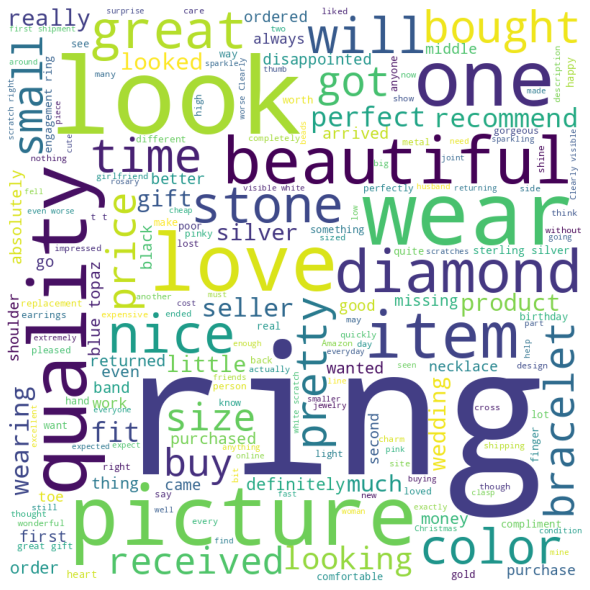

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Convert the set to a space-separated string
word_string = ' '.join(docs)

# Create the WordCloud object
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', 
                      min_font_size = 10).generate(word_string)

# Plot the WordCloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
# Show the plot
plt.show()

In [ ]:
def build_viz(topic_model, n_results):
  _keywords = topic_model.visualize_barchart(top_n_topics=n_results)
  # b = topic_model.visualize_topics()
  _hierachy = topic_model.visualize_hierarchy(top_n_topics=n_results)
  return _keywords, _hierachy

def _build_viz(topic_model, n_results):
  _keywords = topic_model.visualize_barchart(top_n_topics=n_results)
  _topics = topic_model.visualize_topics()
  _hierachy = topic_model.visualize_hierarchy(top_n_topics=n_results)
  return _keywords, _topics, _hierachy

**Visualize the Topic**

Ran into difficulty with the **visualize_topics** method Showed some inconsistent behaviours and kept throwing an error. Sometimes, I got it to work, but not sure why it bugs out again. Room for more improvement.

In [ ]:
# Get the query and rank from the user using input forms
# Fetch the desired number of results
# n_results = 110 #@param {type:"slider", min:50, max:200, step:10}

# query = input("Enter the query:")

# _id_lsi, ndoc_id_lsi, doc_text_lsi, similarity_lsi = search_lsi(query)

In [ ]:
# Perform Search and retrieve the top search results

# _id, doc_id, docs, similarity = search_nir(query, n_results)
# # Build topic for the n returned result
# # a, b, c, d, e = build_topic(docs, vocab, n_results)
# topic_mod = build_topic(docs, vocab, n_results)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

2023-03-24 10:44:11,299 - BERTopic - Transformed documents to Embeddings
2023-03-24 10:44:15,660 - BERTopic - Reduced dimensionality
2023-03-24 10:44:16,537 - BERTopic - Clustered reduced embeddings


In [ ]:
topic_model.visualize_distribution(probs[n_results-1], min_probability=0.0001)

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=n_results)

In [ ]:
topic_model.visualize_barchart(top_n_topics=n_results)

In [ ]:
# viz = list()
for topic in topic_mod:
  try:
    a, c = build_viz(topic, n_results)
    a.show()
    # b.show()
    c.show()
    # d.show()
  except ValueError:  
    pass

# for i in d_topics:
#   i.visualize_topics()


In [ ]:
# for topic in topic_obj:
#   topic.visualize_topics()

# Question 5 - Topic Summarization


#### Install SummerTime

In [ ]:
# Download SummerTime 
# Swith to the Summertime directory

!git clone https://github.com/Yale-LILY/SummerTime.git


Cloning into 'SummerTime'...
remote: Enumerating objects: 4385, done.
remote: Counting objects: 100% (690/690), done.
remote: Compressing objects: 100% (192/192), done.
remote: Total 4385 (delta 598), reused 498 (delta 498), pack-reused 3695
Receiving objects: 100% (4385/4385), 9.84 MiB | 13.77 MiB/s, done.
Resolving deltas: 100% (2407/2407), done.


In [ ]:
%cd SummerTime/
# Pip install Summertime locally

# !pip install -e .

/content/SummerTime


In [ ]:
## Finish setup

# Setup ROUGE (needed to use ROUGE evaluation metric)
!export ROUGE_HOME=/usr/local/bin/python/dist-packages/summ_eval/ROUGE-1.5.5/
!pip install -U  git+https://github.com/bheinzerling/pyrouge.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/bheinzerling/pyrouge.git to /tmp/pip-req-build-jxaj27i9
  Running command git clone --filter=blob:none --quiet https://github.com/bheinzerling/pyrouge.git /tmp/pip-req-build-jxaj27i9
  Resolved https://github.com/bheinzerling/pyrouge.git to commit 08e9cc35d713f718a05b02bf3bb2e29947d436ce
  Preparing metadata (setup.py) ... done
  Created wheel for pyrouge: filename=pyrouge-0.1.3-py3-none-any.whl size=191923 sha256=1f5b7119045475bd500d6c7418c0f2d37bc1c987c07be6d582b085f765c4f040
  Stored in directory: /tmp/pip-ephem-wheel-cache-zxo05o1d/wheels/bd/07/80/f241050743bda1488efce41793a0b5502c97888adf191110d3
Successfully built pyrouge


In [ ]:
# If you've been prompted to restart the kernel in either of the two cells above,
# Please do so
# Then run this cell to go back to the relevant directory

%cd /content/SummerTime/

# !pip install en_core_web_sm==3.0.0
!python -m spacy download en_core_web_sm

/content/SummerTime


In [ ]:
!pip install --upgrade transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.27.2-py3-none-any.whl (6.8 MB)
  Using cached tokenizers-0.13.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.6 MB)
  Using cached huggingface_hub-0.13.3-py3-none-any.whl (199 kB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.10.3
    Uninstalling tokenizers-0.10.3:
      Successfully uninstalled tokenizers-0.10.3
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.0.19
    Uninstalling huggingface-hub-0.0.19:
      Successfully uninstalled huggingface-hub-0.0.19
  Attempting uninstall: transformers
    Found existing installation: transformers 4.5.1
    Uninstalling transformers-4.5.1:
      Successfully uninstalled transformers-4.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of 

#### Implement Summarization

In [ ]:
def build_nir_query_embedding(query, n):
  query_doc = pd.Series(query)
  with torch.no_grad():
      # Tokenization
      tokenized = query_doc[0:n].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

      # padding
      max_len = 0
      q = 0
      for i in tokenized.values:
          
          # BERT only accept maximum 512 values
          if len(i) > 512:
              temp = tokenized.values[q]
              tokenized.values[q] = temp[:512]
              i = tokenized.values[q]
              print('too much tokenized.values for BERT, only 512 are taken')

          # print(len(i))
          if len(i) > max_len:
              max_len = len(i)
          q += 1

      padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
      np.array(padded).shape
      # masking
      attention_mask = np.where(padded != 0, 1, 0)
      attention_mask.shape
      # run the model
      input_ids = torch.tensor(padded)  
      attention_mask = torch.tensor(attention_mask)

      last_hidden_states = model(input_ids, attention_mask=attention_mask)

      query_features = last_hidden_states[0][:,0,:].numpy()
      return query_features 

from prettytable import PrettyTable, ALL

def search_nir(query, n_results=5):
  # Get the query embedding using the BERT-based model
  embedding = build_nir_query_embedding(query, n_results)

  # Calculate the cosine similarity between the query embedding and the document embeddings
  similarity = cosine_similarity(train_features, embedding)

  # Get the indexes of the top n_results most similar documents sorted by similarity score
  indexes = np.argsort(similarity, axis=None)[::-1][:n_results]

  # Get the document IDs, texts, and similarity scores of the top n_results most similar documents
  d_id = [i for i in indexes]
  ndoc_id = [data.iloc[k]['ID'] for k in indexes]
  ndoc_text = [data.iloc[k]['Reviews'] for k in indexes]
  similarity_scores = [np.around(similarity[k], 4) for k in indexes]

  # Return the query IDs, document IDs, document texts, and similarity scores
  return d_id, ndoc_id, ndoc_text, similarity_scores

def print_search_results(d_id, ndoc_id, ndoc_text, similarity_scores):
  # Create a PrettyTable object to format the search results
  results = PrettyTable()

  # Set the field names and formatting options for the table
  results.field_names = ["Rank", "Doc ID", "Score", "Text"]
  results.hrules = ALL
  results.vrules = ALL
  results.align["Rank"] = "c"
  results.align["Doc ID"] = "l"
  results.align["Similarity Score"] = "c"
  results.align["Text"] = "l"
  results.float_format = ".4"

  # Add the query as the first row of the table
  results.add_row(["Query", "", "", query])

  # Add the top n_results most similar documents to the table
  for i in range(n_results):
    results.add_row([i+1, ndoc_id[i], similarity_scores[i],  ndoc_text[i]])

  # Print the formatted table
  print(results)


#### Summarize the top 10 search results for each query in the query list

In [ ]:
from summertime import model

summary_list = list()
for key, corpus in enumerate(corpus_list):
  print('\n' + f"QUERY {key+1} SUMMARIES")
  lexrank = model.LexRankModel(corpus)
  # # Inference
  summary = lexrank.summarize(corpus)
  summary_list.append(summary)
  for i in range(len(summary)):
    print("Summary Review %d: "%(i+1), summary[i])
  

# Get the query and rank from the user using input forms
# Fetch the desired number of results


# Add the top n_results most similar documents to the table
# for i in range(n_results):
#   results.add_row([i+1, ndoc_id[i], similarity_scores[i],  ndoc_text[i]])

# Longformer2Roberta
# longformer = model.LongformerModel()

# longformer_summary = longformer.summarize(corpus)
# for i in range(len(longformer_summary)):
#   print("\nSummary Review %d: "%(i+1), longformer_summary[i])


QUERY 1 SUMMARIES
Summary Review 1:  The seller deals with you in the most professional way and the security measures are superb. A great gift to your loved one and an ever better seller.
Summary Review 2:  the only thing is that if the rings are not position correctly it pinches the skin. i got this ring as a gift from my boyfriend and i love it.
Summary Review 3:  It's a beautifull ring. I bought this as a gift for a friends birthday and she loved it.
Summary Review 4:  It closes firmly with a clic and has a classic look. The look is very beautiful with a smooth finish.
Summary Review 5:  I got this ring for my birthday and I love it, I cannot imagine a woman not adoring this ring.
Summary Review 6:  I got this ring for my birthday and I love it, I cannot imagine a woman not adoring this ring.
Summary Review 7:  I got this as my engagement ring Feb 09 This ring is beautiful and durable. I absolutely love this ring!
Summary Review 8:  Just what I was looking for. It is so pretty and 

In [ ]:
# Fetch the top values to be inputed in ChatGPT to determine target
_values = list()
_summaries = list()

for i, value in enumerate(summary_list):
  _summaries.append(value[0])
  print(f"{i+1} - {value[0]}")

print('\n')

for i, value in enumerate(corpus_list):
  _values.append(value[0])
  print(f"{i+1} - {value[0]}")


1 - The seller deals with you in the most professional way and the security measures are superb. A great gift to your loved one and an ever better seller.
2 - Very disappointed in the appearance and quality of the bracelet and its definitely not worth $45.00 - not even close.
3 - I'm very happy with it and recommend it unreservedly. Item was great quality and came promptly.
4 - very good for everyday wear or dressing up
5 - You can see all the keys, any flute fan would adore having this item. The flute charm is so detailed and is of very high quality.
6 - The silver does not look as in the picture but just like polished silver. the earrings are as in the picture, stones look good and are light and comfortable, reasonable quality for the price.
7 - The ring was nice and looked like picture but had a crack in one Garnet and another one had a large chip.
8 - Really looks like the picture. Silver is nicely finished and the enamel is a nice highlight.


1 - A great gift to your loved one an

#### Evaluation of Summarization

In [ ]:
!pip install tabulate

from tabulate import tabulate
from summertime.evaluation import SUPPORTED_EVALUATION_METRICS
from summertime.evaluation import BertScore, Meteor, Bleu
import summertime.evaluation as st_eval

print(SUPPORTED_EVALUATION_METRICS)

targets = [
    'Gifted a ring to 16-year-old niece who loved and was happy to receive it.',
    'Ring is pretty, but the metal is insubstantial and can easily be pushed in.',
    'High-quality item arrived quickly. Extremely satisfied and wholeheartedly recommend.',
    'Suitable and fashionable for dressy occasions.',
    'Received nice product earlier than expected. Will reorder.',
    'Colorful turtle items resembling the photograph. Comparable to expensive ones, and beautiful.',
    'Ring appears smaller than pictured with very small diamonds, causing disappointment.',
    'Medical alert bracelet matches picture and is made of quality sterling silver.',
]

summaries = _values

# Calculate BertScore
bert_metric = BertScore()
bert_results = bert_metric.evaluate(summaries, targets)

# Calculate Meteor
meteor_metric = Meteor()
meteor_results = meteor_metric.evaluate(summaries, targets)

# Calculate BLEU
bleu_metric = Bleu()
bleu_results = bleu_metric.evaluate(summaries, targets)

# Print evaluation results
print(f"BertScore: {bert_results}")
print(f"Meteor: {meteor_results}")
print(f"BLEU: {bleu_results}")

# Print evaluation results in a table
table_data = [["BertScore", bert_results['bert_score_f1']],
              ["Meteor", meteor_results['meteor']],
              ["BLEU", bleu_results['bleu']]]

print(tabulate(table_data, headers=["Metric", "Score"], tablefmt="grid"))


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[<class 'summertime.evaluation.bertscore_metric.BertScore'>, <class 'summertime.evaluation.bleu_metric.Bleu'>, <class 'summertime.evaluation.rouge_metric.Rouge'>, <class 'summertime.evaluation.rougewe_metric.RougeWe'>, <class 'summertime.evaluation.meteor_metric.Meteor'>]


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


hash_code: bert-base-uncased_L8_no-idf_version=0.3.12(hug_trans=4.27.2)
BertScore: {'bert_score_f1': 0.5041931867599487}
Meteor: {'meteor': 0.05602394087791603}
BLEU: {'bleu': 0.004187602191129517}
+-----------+-----------+
| Metric    |     Score |
+===========+===========+
| BertScore | 0.504193  |
+-----------+-----------+
| Meteor    | 0.0560239 |
+-----------+-----------+
| BLEU      | 0.0041876 |
+-----------+-----------+


Summarize evaluation answer

A BERTScore of 0.504193 indicates that the generated text is related to the reference text, but there is still a significant difference.
A METEOR score of 0.056 indicates that the generated and reference texts have very little in common.
A BLEU score of 0.0041 is extremely low, indicating that the generated text and the reference text are not aligned.

This means a good amount of tunning still needs to be done.

#### 5b - Interactive summarization

In [ ]:
no_sentences = input("Enter number of sentences you desire to be summarized")
# list_val = list()
user_summaries = list()
summary_list = list()
for i in range(0,int(no_sentences)):
  list_val = input(f"Enter sentence {i+1} \n")
  user_summaries.append(list_val)
  lexrank = model.LexRankModel(user_summaries)
  # # Inference
  summary = lexrank.summarize(user_summaries)
  summary_list.append(summary)

for i, val in enumerate(user_summaries):
  print(f"Summary for Sentence {i+1}")
  print(f"Summary {i+1} - {summary_list[i]}")
  print('\n')

  
  sentence_summary = ["Arsenal was founded in 1886 as Dial Square, by workers at the Royal Arsenal in Woolwich. The club's first game was against Eastern Wanderers and ended in a 6-0 victory for Dial Square.",
  "Arsenal is one of the most successful clubs in English football history, having won 13 league titles, 14 FA Cups, and two European trophies. The club's most successful period came under the management of Arsene Wenger, who led the team to three Premier League titles and four FA Cups during his tenure from 1996 to 2018."]
  

Enter number of sentences you desire to be summarized2
Enter sentence 1 
Arsenal was founded in 1886 as Dial Square, by workers at the Royal Arsenal in Woolwich. The club's first game was against Eastern Wanderers and ended in a 6-0 victory for Dial Square.
Enter sentence 2 
Arsenal is one of the most successful clubs in English football history, having won 13 league titles, 14 FA Cups, and two European trophies. The club's most successful period came under the management of Arsene Wenger, who led the team to three Premier League titles and four FA Cups during his tenure from 1996 to 2018.
Summary for Sentence 1
Summary 1 - ["The club's first game was against Eastern Wanderers and ended in a 6-0 victory for Dial Square. Arsenal was founded in 1886 as Dial Square, by workers at the Royal Arsenal in Woolwich."]


Summary for Sentence 2
Summary 2 - ["The club's first game was against Eastern Wanderers and ended in a 6-0 victory for Dial Square. Arsenal was founded in 1886 as Dial Square, 

In [ ]:
no_sentences = input("Enter number of sentences you desire to be summarized: ")
user_summaries = []
summary_list = []
for i in range(int(no_sentences)):
    list_val = input(f"Enter sentence {i+1}: \n")
    user_summaries.append(list_val)
    # user_summaries.append([list_val]))

for i, val in enumerate(user_summaries):  
  lexrank = model.LexRankModel(user_summaries)
  # Inference
  summary = lexrank.summarize([user_summaries[i]])
  summary_list.append(summary)
  print(f"="*200)
  print(f"\nSummary for Sentence {i+1}")
  print(f"Summarized Sentence {i+1} - {user_summaries[i]}")
  print(f"Summary {i+1} - {summary[0]}")
  print('\n')

Enter number of sentences you desire to be summarized: 2
Enter sentence 1: 
Arsenal is one of the most successful clubs in English football history, having won 13 league titles, 14 FA Cups, and two European trophies. The club's most successful period came under the management of Arsene Wenger, who led the team to three Premier League titles and four FA Cups during his tenure from 1996 to 2018.
Enter sentence 2: 
Arsenal was founded in 1886 as Dial Square, by workers at the Royal Arsenal in Woolwich. The club's first game was against Eastern Wanderers and ended in a 6-0 victory for Dial Square.

Summary for Sentence 1
Summarized Sentence 1 - Arsenal is one of the most successful clubs in English football history, having won 13 league titles, 14 FA Cups, and two European trophies. The club's most successful period came under the management of Arsene Wenger, who led the team to three Premier League titles and four FA Cups during his tenure from 1996 to 2018.
Summary 1 - The club's most su

In [ ]:
no_sentences = input("Enter number of sentences you desire to be summarized: ")
max_words = int(input("Enter maximum number of words for the summary: "))
user_summaries = []
summary_list = []
for i in range(int(no_sentences)):
    list_val = input(f"Enter sentence {i+1}: \n")
    user_summaries.append(list_val)

for i, val in enumerate(user_summaries):  
    lexrank = model.LexRankModel(user_summaries)
    # Inference
    summary = lexrank.summarize([user_summaries[i]])
    # Split summary into words and join only the desired number of words
    summary_words = summary[0].split()[:max_words]
    summary = ' '.join(summary_words)
    summary_list.append(summary)
    print('\n')
    print(f"Summary for Sentence {i+1}")
    print(f"Summarized Sentence {i+1} - {user_summaries[i]}")
    print(f"Summary {i+1} - {summary}")
    print('\n')

Enter number of sentences you desire to be summarized: 2
Enter maximum number of words for the summary: 20
Enter sentence 1: 
Arsenal was founded in 1886 as Dial Square, by workers at the Royal Arsenal in Woolwich. The club's first game was against Eastern Wanderers and ended in a 6-0 victory for Dial Square.
Enter sentence 2: 
Arsenal is one of the most successful clubs in English football history, having won 13 league titles, 14 FA Cups, and two European trophies. The club's most successful period came under the management of Arsene Wenger, who led the team to three Premier League titles and four FA Cups during his tenure from 1996 to 2018.


Summary for Sentence 1
Summarized Sentence 1 - Arsenal was founded in 1886 as Dial Square, by workers at the Royal Arsenal in Woolwich. The club's first game was against Eastern Wanderers and ended in a 6-0 victory for Dial Square.
Summary 1 - The club's first game was against Eastern Wanderers and ended in a 6-0 victory for Dial Square. Arsenal

In [ ]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

In [3]:
# %%shell 
!jupyter nbconvert --to pdf '/content/drive/My Drive/Colab Notebooks/COP509cw/F218341_final_NLPCoursework.ipynb'

[NbConvertApp] Converting notebook /content/drive/My Drive/Colab Notebooks/COP509cw/F218341_final_NLPCoursework.ipynb to pdf
/usr/local/lib/python3.9/dist-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['text/html']) is not able to be represented.
  warn(
/usr/local/lib/python3.9/dist-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['text/html']) is not able to be represented.
  warn(
/usr/local/lib/python3.9/dist-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['text/html']) is not able to be represented.
  warn(
[NbConvertApp] Support files will be in F218341_final_NLPCoursework_files/
[NbConvertApp] Making directory ./F218341_final_NLPCoursework_files
[NbConvertApp] Making directory ./F218341_final_NLPCoursework_files
[NbConvertApp] Making directory ./F218341_final_NLPCoursework_files
[NbConvertApp] Making directory ./F218